### Name: IFEANYI ANTHONY OKPALA
### Student Number: 202203449

Assignment - Applied AI  771767

Task: Implementing a deep learning-based system for image analysis. 

### Data Source 
The image dataset used for this project was gotten from an open source on kaggle (Sai, 2022).

`Link to source data`: https://www.kaggle.com/datasets/hemanthsai7/solar-panel-dust-detection

### Process diagram
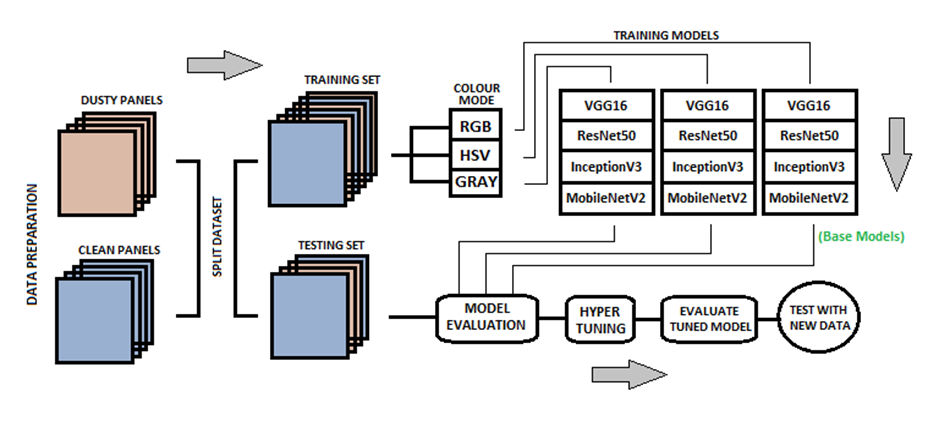
Let's first import all neccessary libraries used for this project.

In [1]:
# Importing Libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras.applications import VGG16, mobilenet_v2

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report

import keras_tuner as kt

import cv2
import itertools

%matplotlib inline

In [2]:
# Assigning variable names to our path directories for the train, validation and new sample test data.
# N.B: Case alphabet insignificant in calling path.

train_path = 'C:/Users/701316/OneDrive - hull.ac.uk/Applied AI Assignment/Applied AI Image Data/train'
val_path = 'C:/Users/701316/OneDrive - hull.ac.uk/Applied AI Assignment/Applied AI Image Data/val'
test_path = 'C:/Users/701316/OneDrive - hull.ac.uk/Applied AI Assignment/Applied AI Image Data/test'

(150, 150, 3)


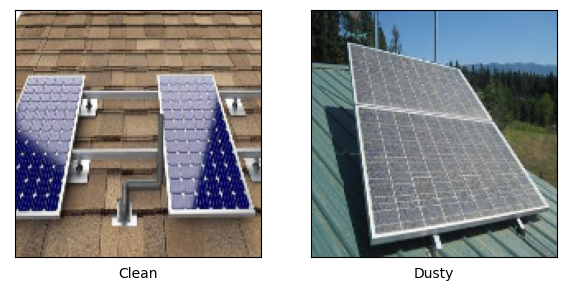

In [3]:
# It is important to see what the image of a clean panel and a dusty panel looks like in our data set.

clean_panels = "C:/Users/701316/OneDrive - hull.ac.uk/Applied AI Assignment/Applied AI Image Data/Train/Clean/Clean 8.jpg"  
dirty_panels = "C:/Users/701316/OneDrive - hull.ac.uk/Applied AI Assignment/Applied AI Image Data/Train/Dusty/Dusty 7.jpg"

plt.rcParams["figure.figsize"] = (7,7)
for idx, path in enumerate([clean_panels,dirty_panels],1):
    img = cv2.imread(path)                                  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                  
    img = cv2.resize(img, (150, 150))
    plt.subplot(1, 2, idx)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(path.split('/')[7])
    plt.grid(visible=None)
    plt.xticks([])
    plt.yticks([])
    
print(img.shape)

In [4]:
# Let's create useful functions to simplify our task. 
# First we will need to convert our gray scale into three channels.

def gray(image):
    
    """
    converting gray scale single channel to 3 channels
    
    """
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Convert to 3-channel image
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    
    return img_color

In [5]:
# Create a function which return different CV colour mode that will be used for data augumentation.

def preprocess_io(mode = None):
    
    """
    This is a function that will be passed
    into the ImageDataGenerator as a data 
    augumentation parameter. This returns 
    the output of the sub function within.
    Takes in a callable parameter 'mode'
    
    """
    def preprocess_img(image):
        
        """
        This funtion returns the result of each mode.
        N.B: The grayscale function is also passed 
        into this function
        
        """
        np_image = np.array(image)
        
        match mode:
            
            case 'HSV':
                image_hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
                result = image_hsv
            case 'RGB':
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                result = image_rgb    
            case 'GRAY':
                image_gry = gray(image)
                result = image_gry 
            
        return result
    return preprocess_img


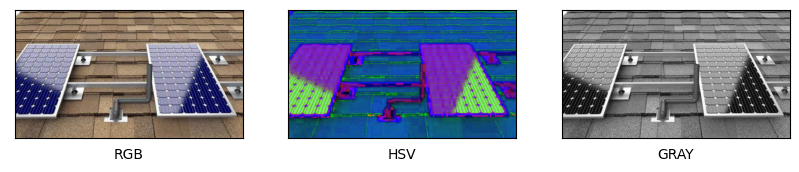

In [6]:
# Let's see the output of each colour mode from the function above.

modes = ['RGB', 'HSV', 'GRAY']

image = cv2.imread('C:/Users/701316/OneDrive - hull.ac.uk/Applied AI Assignment/Applied AI Image Data/Train/Clean/Clean 8.jpg')

plt.rcParams["figure.figsize"] = (10,10)

for n, mode in enumerate(modes,1):
    plt.subplot(1, 3, n)
    preprocess_func = preprocess_io(mode=mode)
    result_image = preprocess_func(image)
    plt.imshow(result_image)
    plt.xlabel(mode)
    plt.grid(visible=None)
    plt.xticks([])
    plt.yticks([])

In this section, we will need to create a function which includes a nested loop to be able to iterate both the computer vision colour modes and the CNN pre-trained models with the application of transfer learning at the classification stage of each CNN architecture.

### Model Function
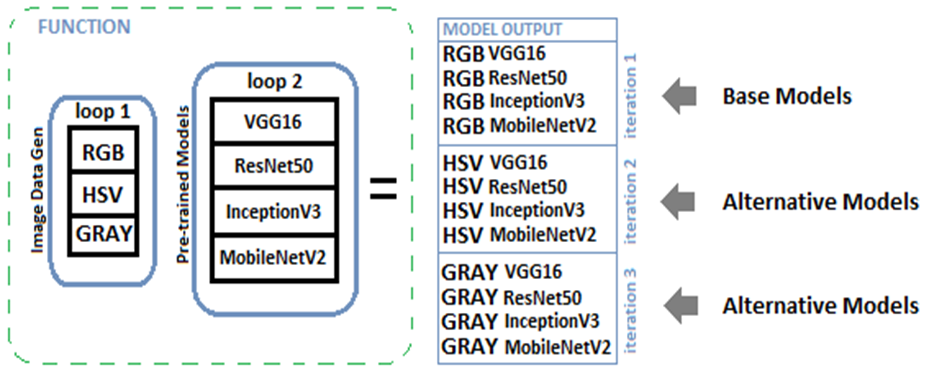

In [7]:
# Pre-trained models with my input parameter.

vgg = VGG16(input_shape = (150,150,3), weights = 'imagenet', include_top = False)
resnet = ResNet50(input_shape=(150, 150, 3), weights='imagenet', include_top=False)
inception = InceptionV3(input_shape=(150, 150, 3), weights='imagenet', include_top=False)
mobilenet = MobileNetV2(input_shape=(150, 150, 3), weights='imagenet', include_top=False)

In [8]:
# Before calling this function, it is important to save each output for proper analysis in a list.

pmodel = {'VGG':vgg, 'ResNet':resnet, 'Inception':inception, 'Mobilenet':mobilenet}

loss_data = []
accuracy_data = []
name_data = []
directory = []
params_count = []


def ComV_Pmodel(modes, pmodel):
    
    """
    This function includes a nested loop to be able to iterate
    both the computer vision colour modes and the CNN pre-trained
    models with the application of transfer learning at the
    classification stage of each CNN architecture.
    
    This function takes in two parameters,the mode 
    and the pretrained model of identical input.
    
    This function also includes the data augumentation process,
    the traing process, and performance evaluation.
    
    Transfer learning was also applied on the pre-trained models as well.
    
    """
    
    for mode in modes:
        
        for pm in pmodel.items():
            
            print(f"\nModel using {pm[0]} with CV colour mode {mode}\n")

        
            train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    preprocessing_function= preprocess_io(mode= mode))


            test_datagen = ImageDataGenerator(rescale=1./255)


            train_generator = train_datagen.flow_from_directory(
                    directory=train_path,
                    target_size=(150, 150),
                    batch_size=32,
                    class_mode='binary')

            validation_generator = test_datagen.flow_from_directory(
                    directory=val_path,
                    target_size=(150, 150),
                    batch_size=32,
                    shuffle=False,
                    class_mode='binary')

            test_generator = test_datagen.flow_from_directory(
                    directory=test_path,
                    target_size=(150, 150),
                    batch_size=32,
                    shuffle=False,
                    class_mode=None)


            images, labels=next(train_generator)
            
   
            for layer in pm[1].layers:
                
                layer.trainable = False
                
                

            mc = ModelCheckpoint(filepath=f'D:/Applied AI (save)/model_{pm[0]}{mode}.h5',
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True)

            es = EarlyStopping(monitor='val_accuracy',
                               min_delta=0.01,
                               patience=10,
                               verbose=1)
            cb = [mc,es]

            x = layers.Flatten()(pm[1].output)
            x = layers.Dense(2048, activation ='relu')(x)
            x = layers.Dense(2048, activation='relu')(x)
            x = layers.Dropout(0.2)(x)
            x = layers.Dense(2, activation='softmax')(x)
            

            model = Model(inputs = pm[1].input, outputs = x)
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
            history = model.fit(train_generator, steps_per_epoch=10, epochs=10,validation_data= validation_generator, callbacks=cb)

            model = load_model(f'D:/Applied AI (save)/model_{pm[0]}{mode}.h5')
            loss, accuracy = model.evaluate(validation_generator)
            name_data.append(f"{pm[0]} with {mode}")
            loss_data.append(round(loss, 3))
            accuracy_data.append(round(accuracy, 3))
            directory.append(f'D:/Applied AI (save)/model_{pm[0]}{mode}.h5')
            params_count.append(model.count_params())
            print(f'loss:{loss}')
            print(f'accuracy:{accuracy}')
            
            
            history_df = pd.DataFrame(history.history)

            fig, axs = plt.subplots(ncols=2, figsize=(12,4), dpi=200)

            # Plot for loss
            axs[0].plot(history_df['loss'], label='training_loss')
            axs[0].plot(history_df['val_loss'], label='val_loss')
            axs[0].set_xlabel('Epochs')
            axs[0].set_ylabel('Loss')
            axs[0].legend()
            

            # Plot for accuracy
            axs[1].plot(history_df['accuracy'], label='training_accuracy')
            axs[1].plot(history_df['val_accuracy'], label='val_accuracy')
            axs[1].set_xlabel('Epochs')
            axs[1].set_ylabel('Accuracy')
            axs[1].legend()
            
            # Set title
            fig.suptitle(f"\nModel using {pm[0]} with CV colour mode {mode}\n", fontsize=16, fontweight='bold', y=1.1)
            
            plt.show()
            
            
    return train_generator, validation_generator, test_generator,train_datagen, test_datagen


Model using VGG with CV colour mode RGB

Found 1588 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 8 images belonging to 1 classes.
Epoch 1/10


C:\Program Files\Python310\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 [==============================] - ETA: 0s - loss: 2.1510 - accuracy: 0.5781
Epoch 1: val_accuracy improved from -inf to 0.43598, saving model to D:/Applied AI (save)\model_VGGRGB.h5
10/10 [==============================] - 10s 846ms/step - loss: 2.1510 - accuracy: 0.5781 - val_loss: 0.8261 - val_accuracy: 0.4360
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6351 - accuracy: 0.6313
Epoch 2: val_accuracy improved from 0.43598 to 0.72561, saving model to D:/Applied AI (save)\model_VGGRGB.h5
10/10 [==============================] - 8s 866ms/step - loss: 0.6351 - accuracy: 0.6313 - val_loss: 0.5362 - val_accuracy: 0.7256
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.5594 - accuracy: 0.7125
Epoch 3: val_accuracy improved from 0.72561 to 0.81707, saving model to D:/Applied AI (save)\model_VGGRGB.h5
10/10 [==============================] - 8s 825ms/step - loss: 0.5594 - accuracy: 0.7125 - val_loss: 0.4579 - val_accuracy: 0.8171
Epoch 4/10


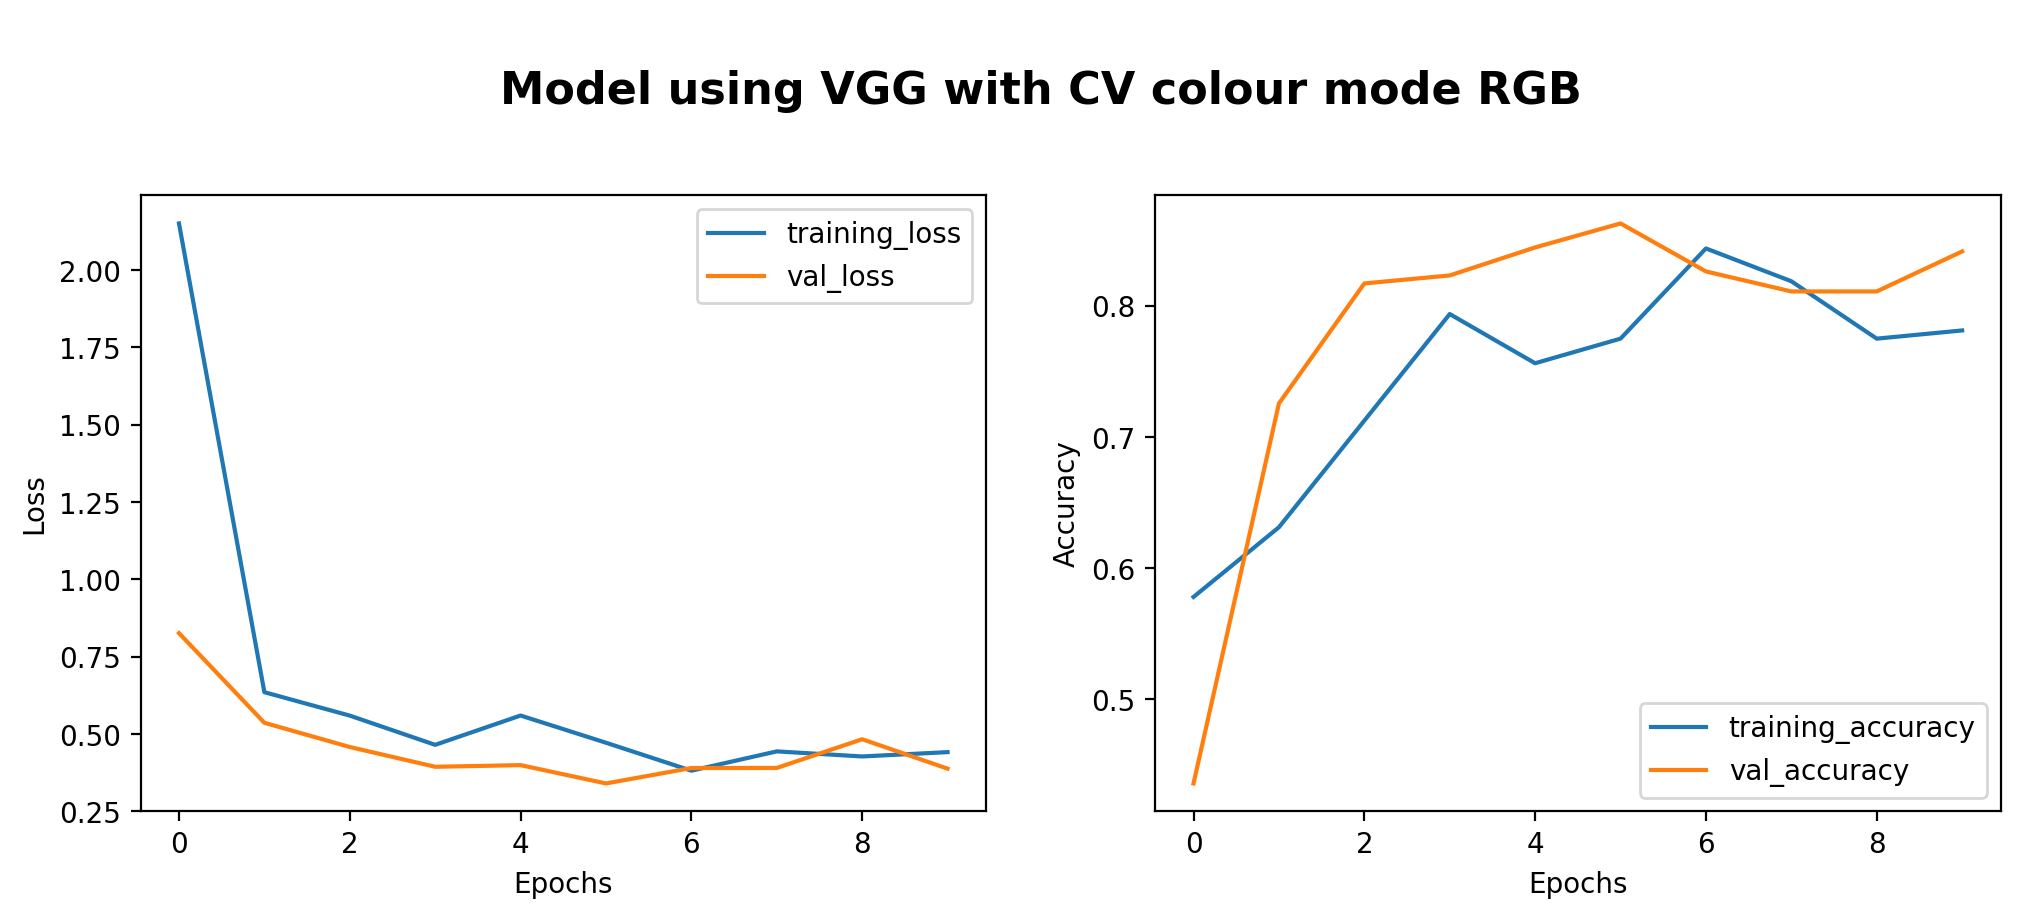


Model using ResNet with CV colour mode RGB

Found 1588 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 8 images belonging to 1 classes.
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 3.8345 - accuracy: 0.5312
Epoch 1: val_accuracy improved from -inf to 0.58232, saving model to D:/Applied AI (save)\model_ResNetRGB.h5
10/10 [==============================] - 17s 2s/step - loss: 3.8345 - accuracy: 0.5312 - val_loss: 1.3239 - val_accuracy: 0.5823
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9145 - accuracy: 0.4875
Epoch 2: val_accuracy did not improve from 0.58232
10/10 [==============================] - 7s 667ms/step - loss: 0.9145 - accuracy: 0.4875 - val_loss: 0.7261 - val_accuracy: 0.5823
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7751 - accuracy: 0.5031
Epoch 3: val_accuracy did not improve from 0.58232
10/10 [==============================] - 7s 682ms/step - loss: 0.7751 - accuracy

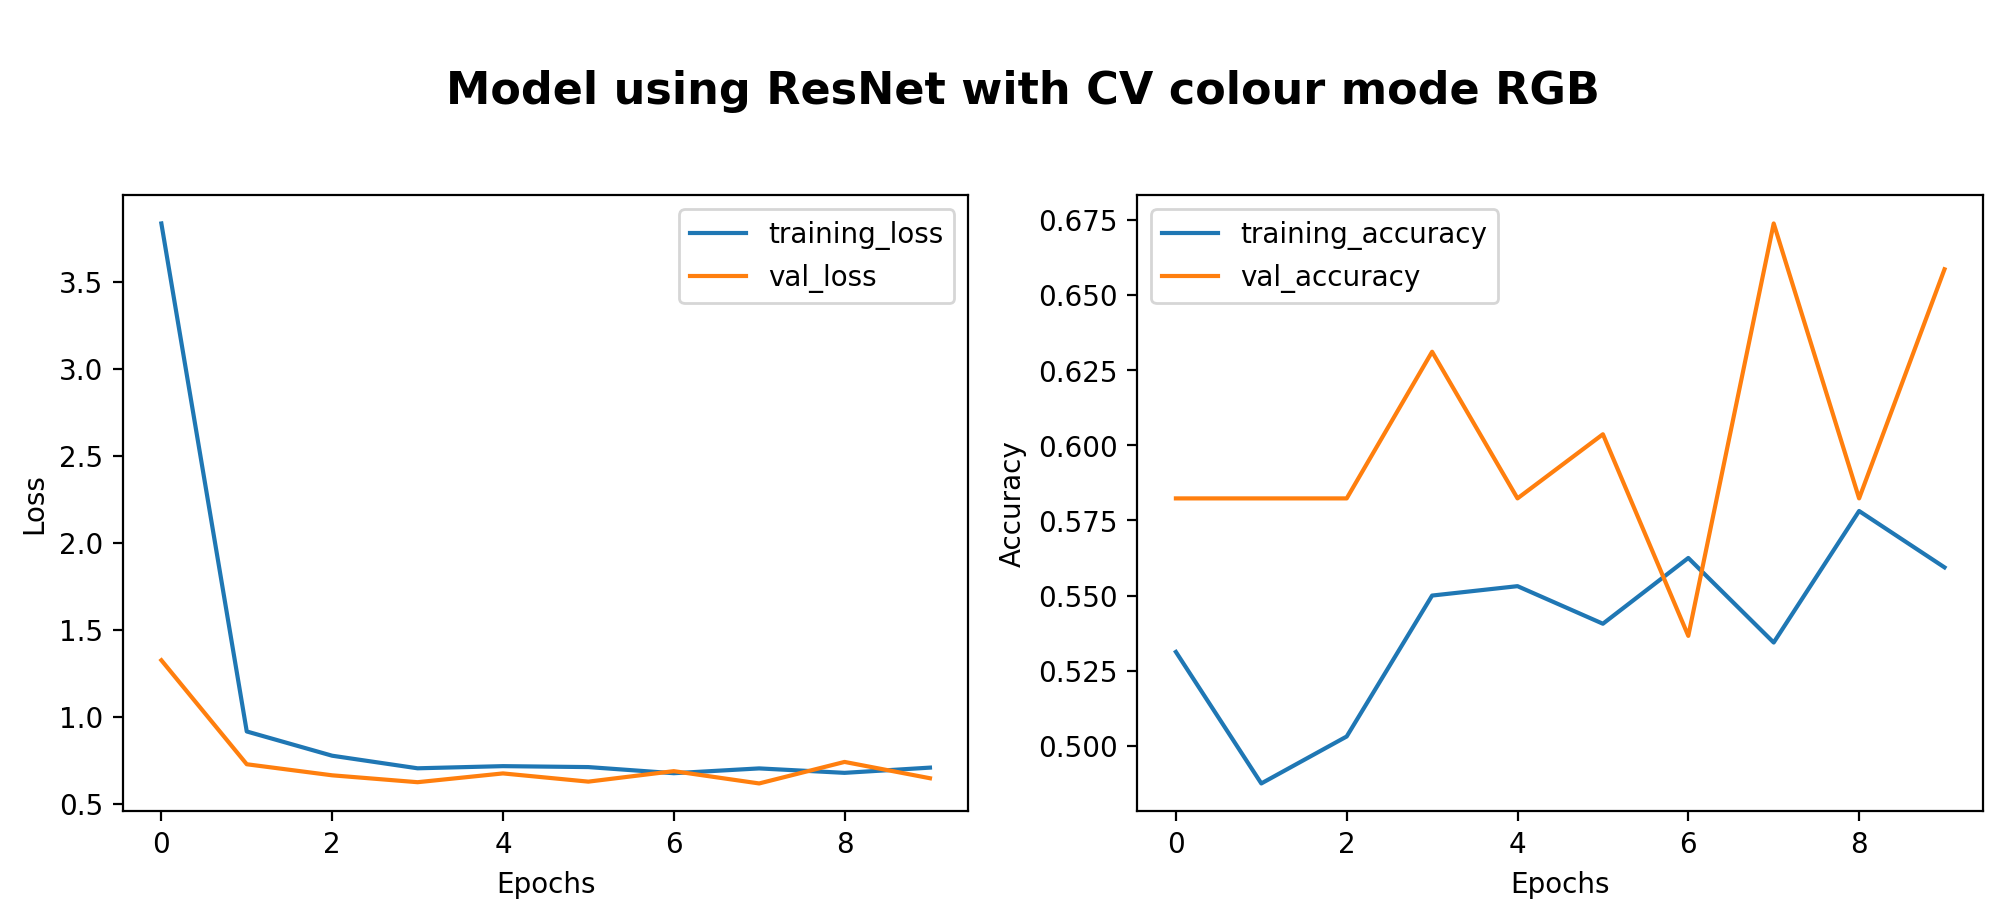


Model using Inception with CV colour mode RGB

Found 1588 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 8 images belonging to 1 classes.
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 33.0163 - accuracy: 0.4844
Epoch 1: val_accuracy improved from -inf to 0.41768, saving model to D:/Applied AI (save)\model_InceptionRGB.h5
10/10 [==============================] - 13s 1s/step - loss: 33.0163 - accuracy: 0.4844 - val_loss: 13.0042 - val_accuracy: 0.4177
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 4.9729 - accuracy: 0.4906
Epoch 2: val_accuracy improved from 0.41768 to 0.46341, saving model to D:/Applied AI (save)\model_InceptionRGB.h5
10/10 [==============================] - 11s 1s/step - loss: 4.9729 - accuracy: 0.4906 - val_loss: 1.4666 - val_accuracy: 0.4634
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 1.0867 - accuracy: 0.6031
Epoch 3: val_accuracy improved from 0.46341 to 0.67378, savi

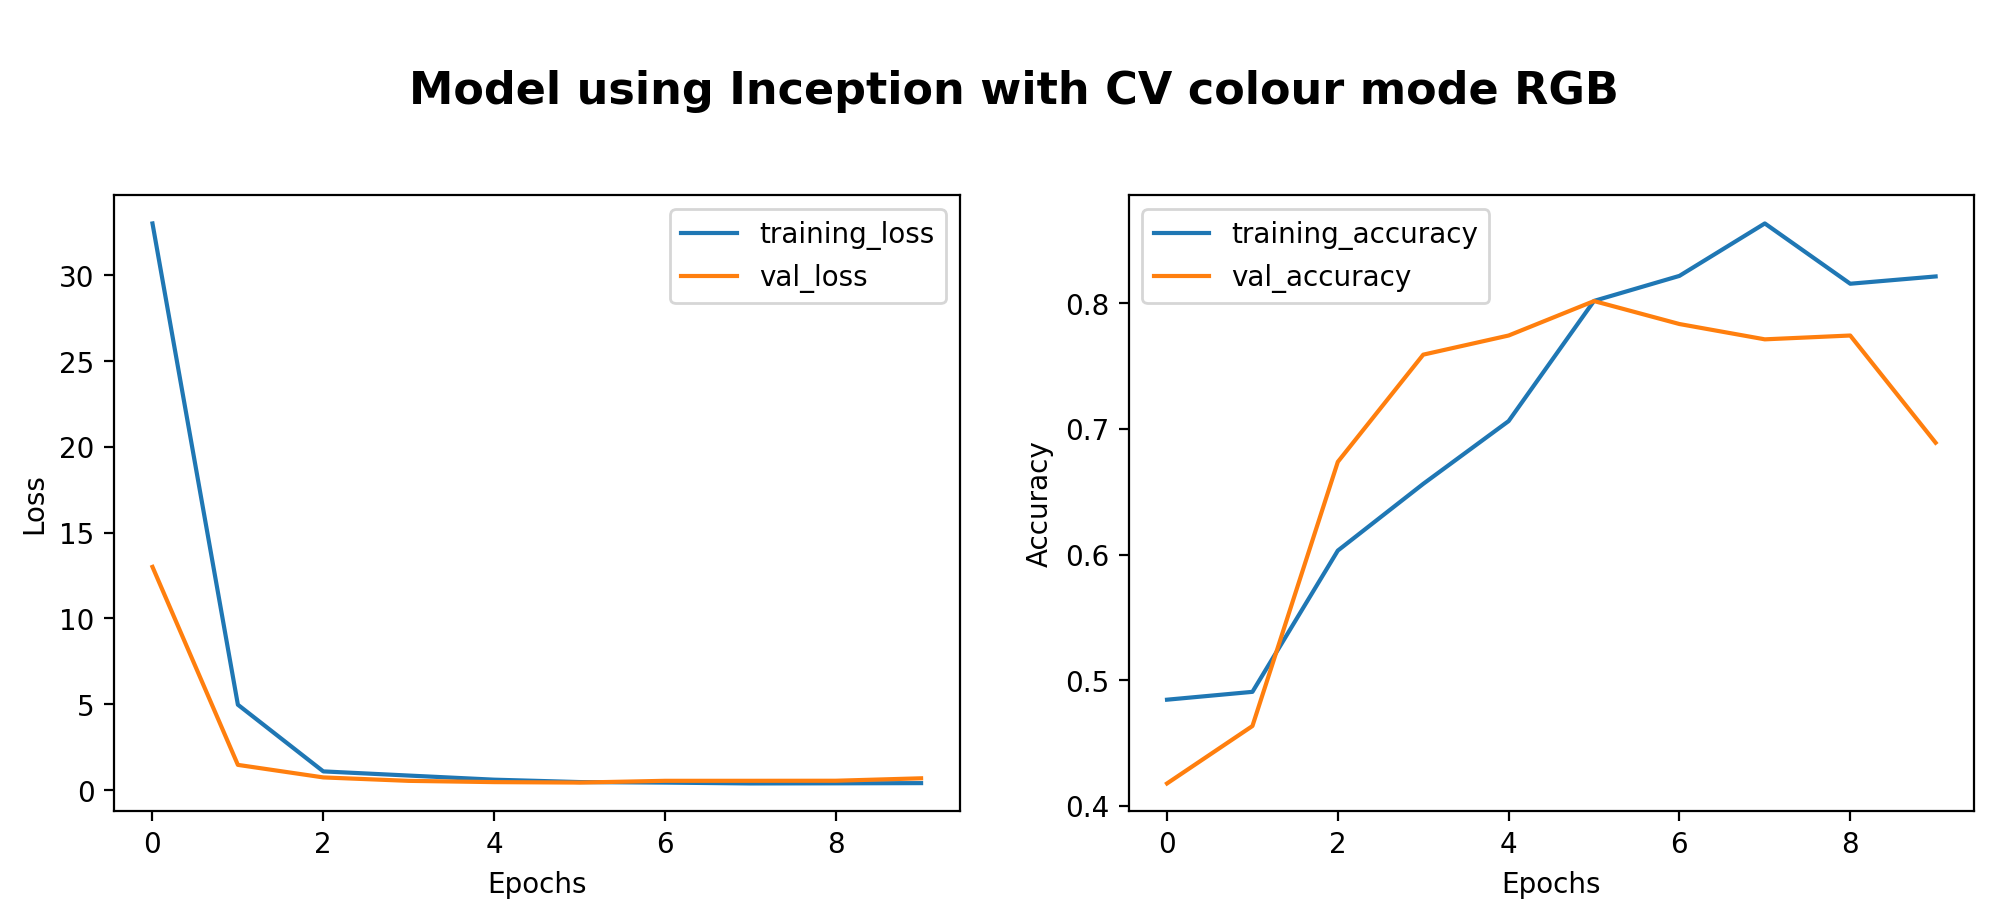


Model using Mobilenet with CV colour mode RGB

Found 1588 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 8 images belonging to 1 classes.
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 35.7678 - accuracy: 0.4773
Epoch 1: val_accuracy improved from -inf to 0.42073, saving model to D:/Applied AI (save)\model_MobilenetRGB.h5
10/10 [==============================] - 13s 1s/step - loss: 35.7678 - accuracy: 0.4773 - val_loss: 3.6309 - val_accuracy: 0.4207
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 2.3135 - accuracy: 0.6187
Epoch 2: val_accuracy improved from 0.42073 to 0.75610, saving model to D:/Applied AI (save)\model_MobilenetRGB.h5
10/10 [==============================] - 13s 1s/step - loss: 2.3135 - accuracy: 0.6187 - val_loss: 0.9776 - val_accuracy: 0.7561
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.7250
Epoch 3: val_accuracy improved from 0.75610 to 0.81402, savin

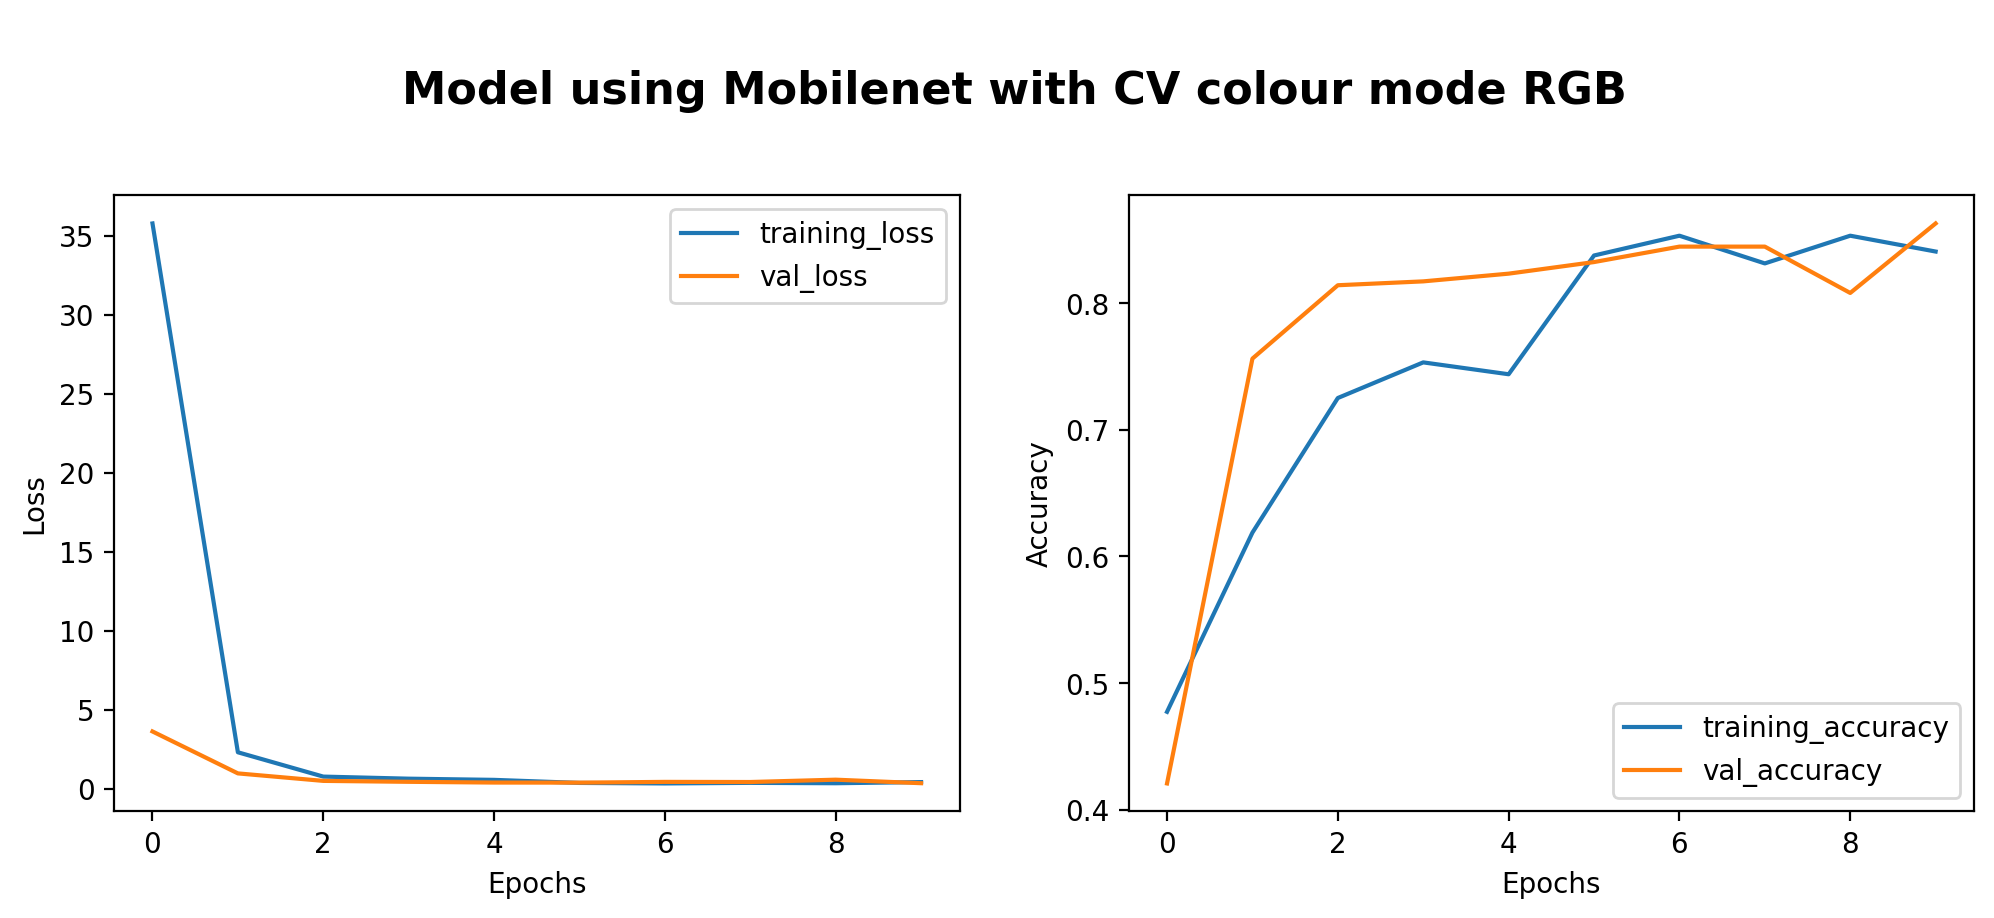


Model using VGG with CV colour mode HSV

Found 1588 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 8 images belonging to 1 classes.
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 3.1729 - accuracy: 0.4406
Epoch 1: val_accuracy improved from -inf to 0.58232, saving model to D:/Applied AI (save)\model_VGGHSV.h5
10/10 [==============================] - 9s 898ms/step - loss: 3.1729 - accuracy: 0.4406 - val_loss: 0.7057 - val_accuracy: 0.5823
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.7433 - accuracy: 0.5594
Epoch 2: val_accuracy did not improve from 0.58232
10/10 [==============================] - 7s 702ms/step - loss: 0.7433 - accuracy: 0.5594 - val_loss: 0.6215 - val_accuracy: 0.5823
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.6250
Epoch 3: val_accuracy improved from 0.58232 to 0.76829, saving model to D:/Applied AI (save)\model_VGGHSV.h5
10/10 [===================

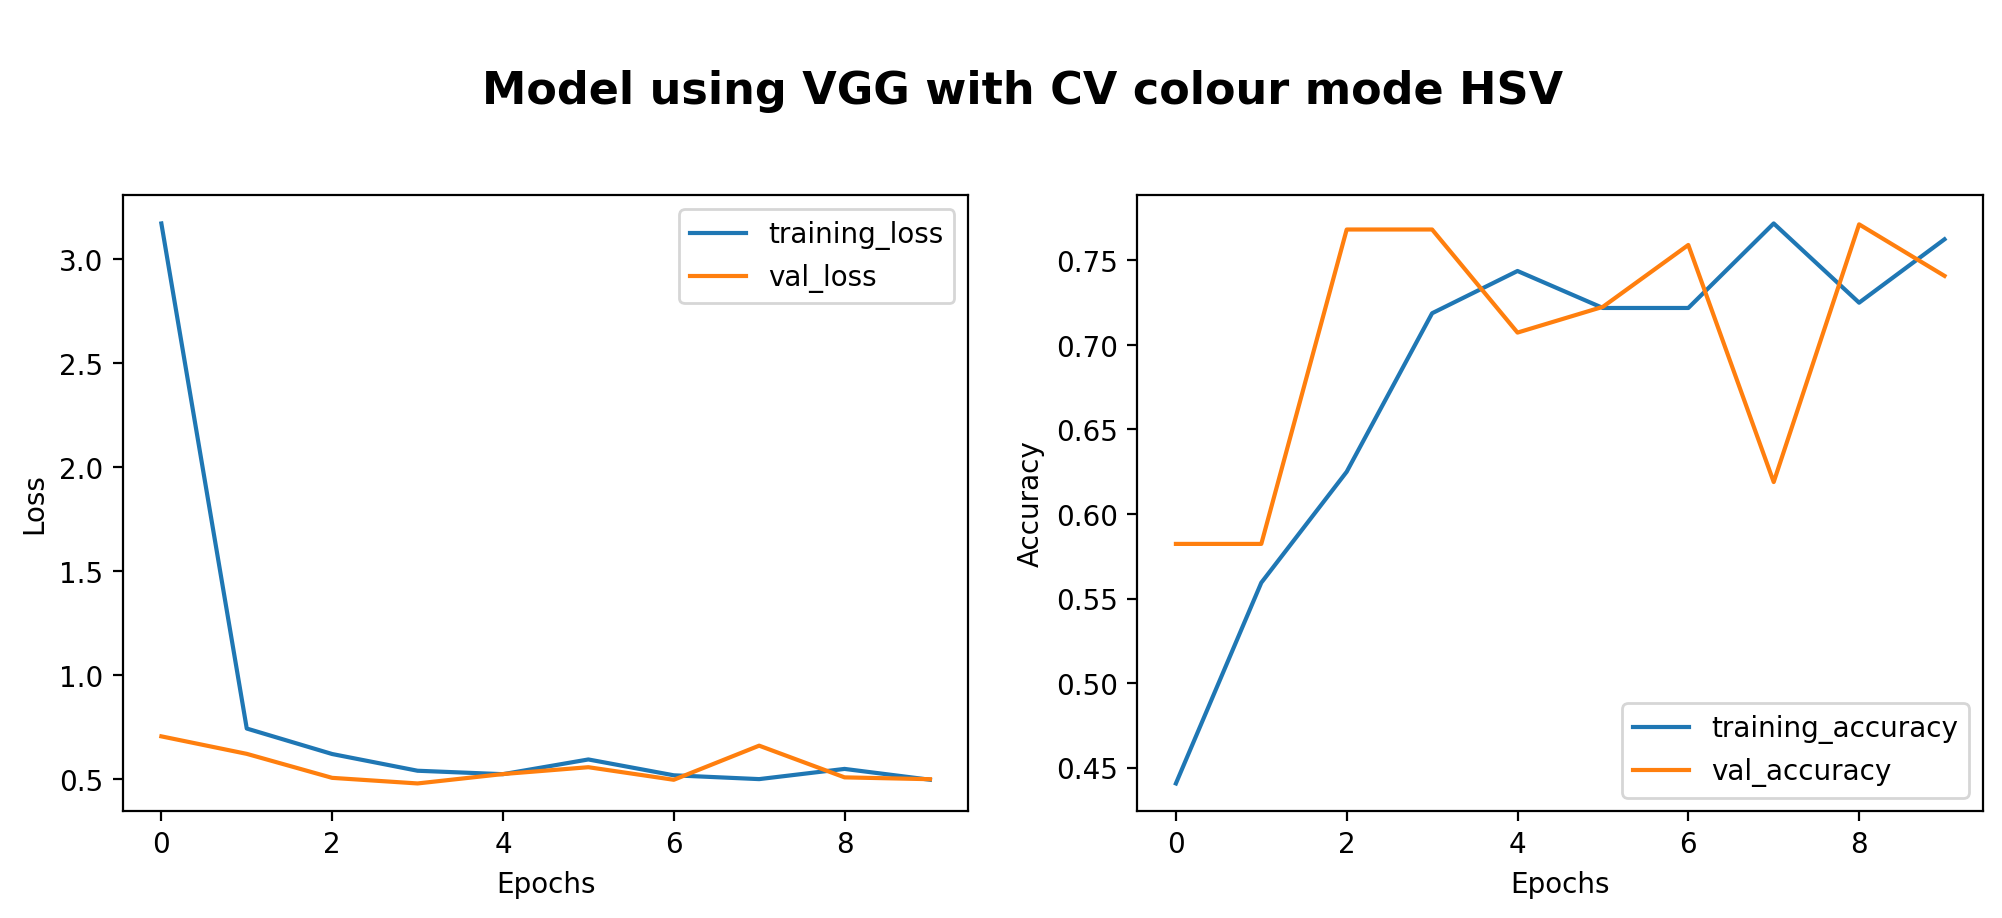


Model using ResNet with CV colour mode HSV

Found 1588 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 8 images belonging to 1 classes.
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 7.4442 - accuracy: 0.5063
Epoch 1: val_accuracy improved from -inf to 0.41768, saving model to D:/Applied AI (save)\model_ResNetHSV.h5
10/10 [==============================] - 17s 2s/step - loss: 7.4442 - accuracy: 0.5063 - val_loss: 2.4394 - val_accuracy: 0.4177
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.1719 - accuracy: 0.5281
Epoch 2: val_accuracy improved from 0.41768 to 0.58232, saving model to D:/Applied AI (save)\model_ResNetHSV.h5
10/10 [==============================] - 15s 2s/step - loss: 1.1719 - accuracy: 0.5281 - val_loss: 0.6836 - val_accuracy: 0.5823
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.8016 - accuracy: 0.4375
Epoch 3: val_accuracy did not improve from 0.58232
10/10 [==============

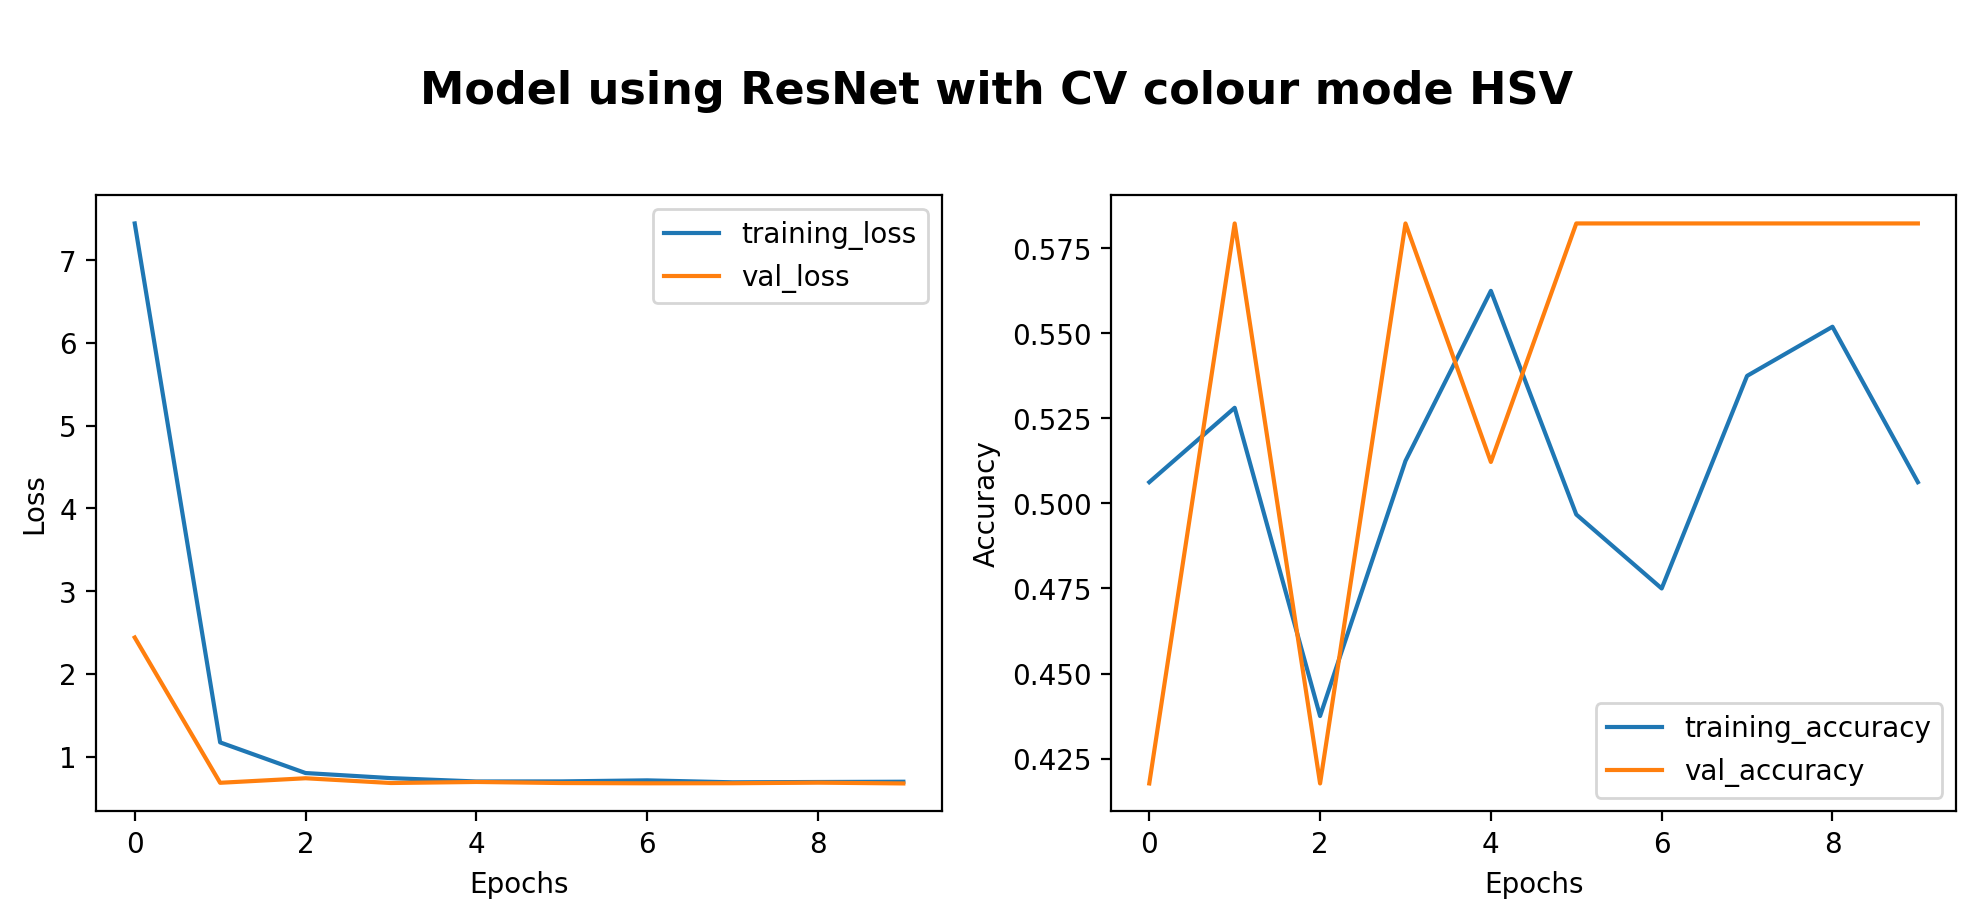


Model using Inception with CV colour mode HSV

Found 1588 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 8 images belonging to 1 classes.
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 30.7257 - accuracy: 0.5063
Epoch 1: val_accuracy improved from -inf to 0.41768, saving model to D:/Applied AI (save)\model_InceptionHSV.h5
10/10 [==============================] - 12s 1s/step - loss: 30.7257 - accuracy: 0.5063 - val_loss: 7.2132 - val_accuracy: 0.4177
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 2.8612 - accuracy: 0.5406
Epoch 2: val_accuracy improved from 0.41768 to 0.58232, saving model to D:/Applied AI (save)\model_InceptionHSV.h5
10/10 [==============================] - 11s 1s/step - loss: 2.8612 - accuracy: 0.5406 - val_loss: 2.5570 - val_accuracy: 0.5823
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 1.0613 - accuracy: 0.6594
Epoch 3: val_accuracy improved from 0.58232 to 0.66463, savin

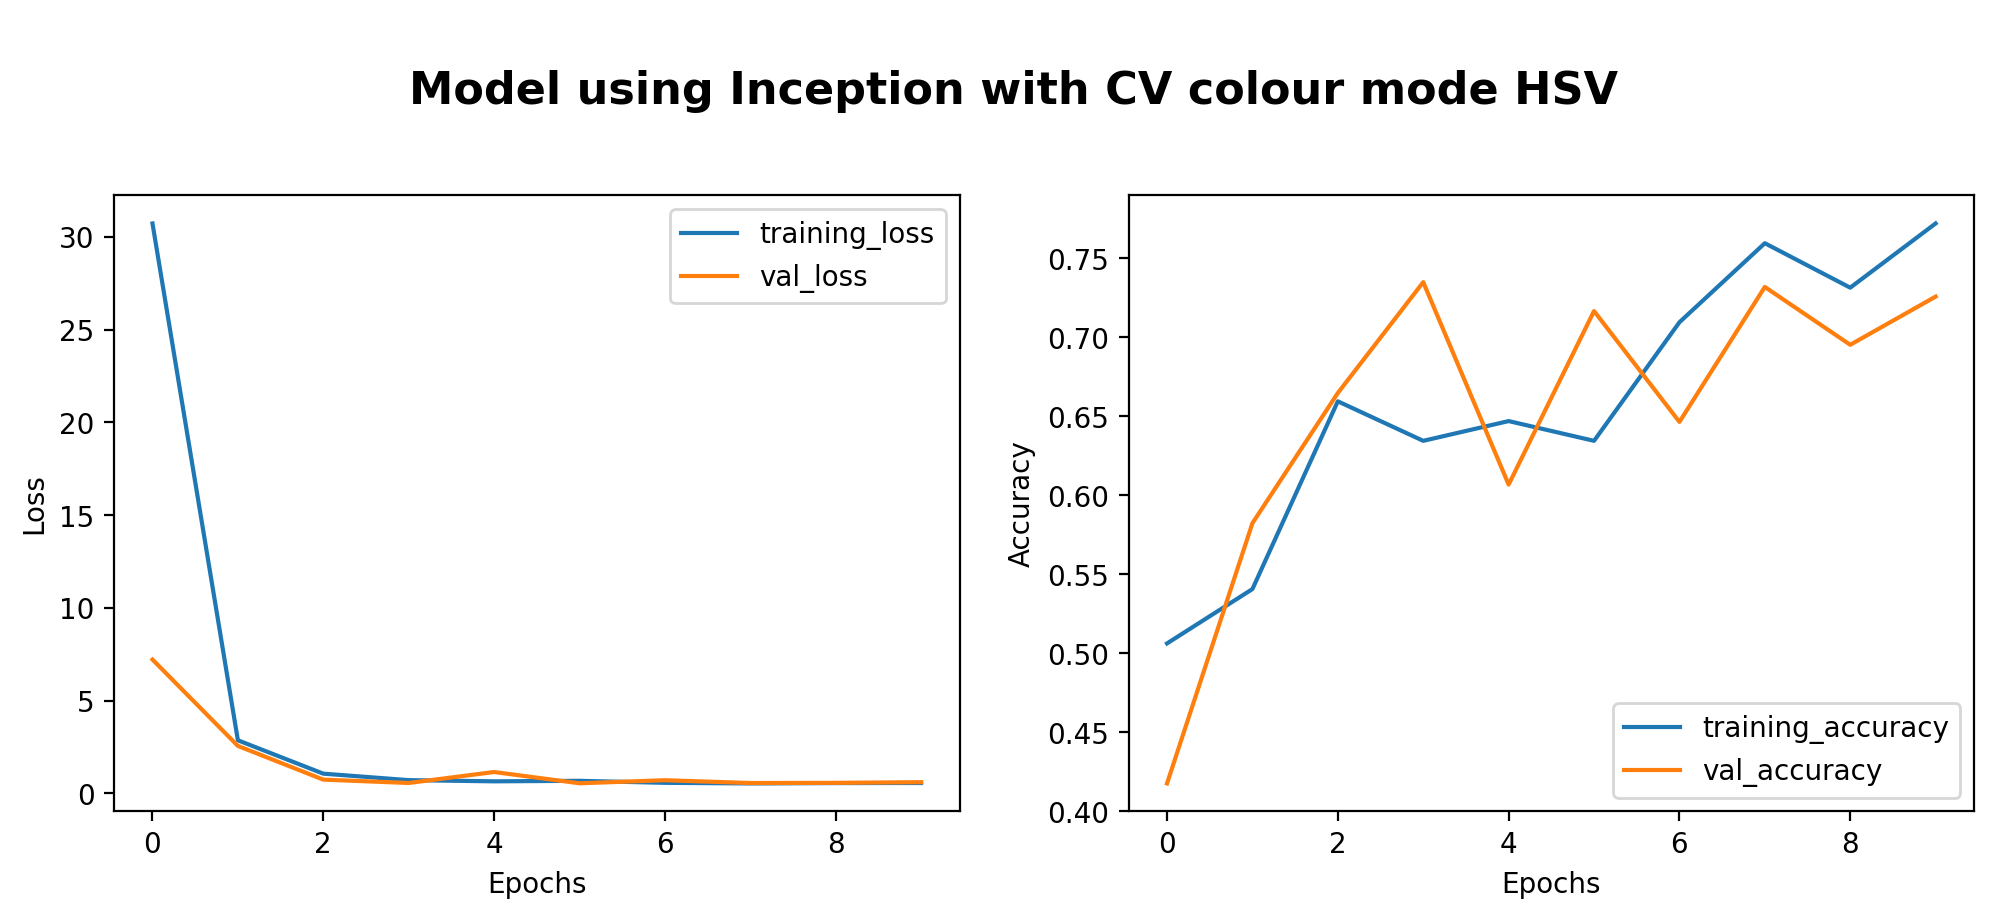


Model using Mobilenet with CV colour mode HSV

Found 1588 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 8 images belonging to 1 classes.
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 23.9719 - accuracy: 0.4906
Epoch 1: val_accuracy improved from -inf to 0.64024, saving model to D:/Applied AI (save)\model_MobilenetHSV.h5
10/10 [==============================] - 14s 1s/step - loss: 23.9719 - accuracy: 0.4906 - val_loss: 2.1220 - val_accuracy: 0.6402
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 2.6786 - accuracy: 0.6094
Epoch 2: val_accuracy improved from 0.64024 to 0.69207, saving model to D:/Applied AI (save)\model_MobilenetHSV.h5
10/10 [==============================] - 12s 1s/step - loss: 2.6786 - accuracy: 0.6094 - val_loss: 0.8436 - val_accuracy: 0.6921
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.9756 - accuracy: 0.6526
Epoch 3: val_accuracy improved from 0.69207 to 0.70122, savin

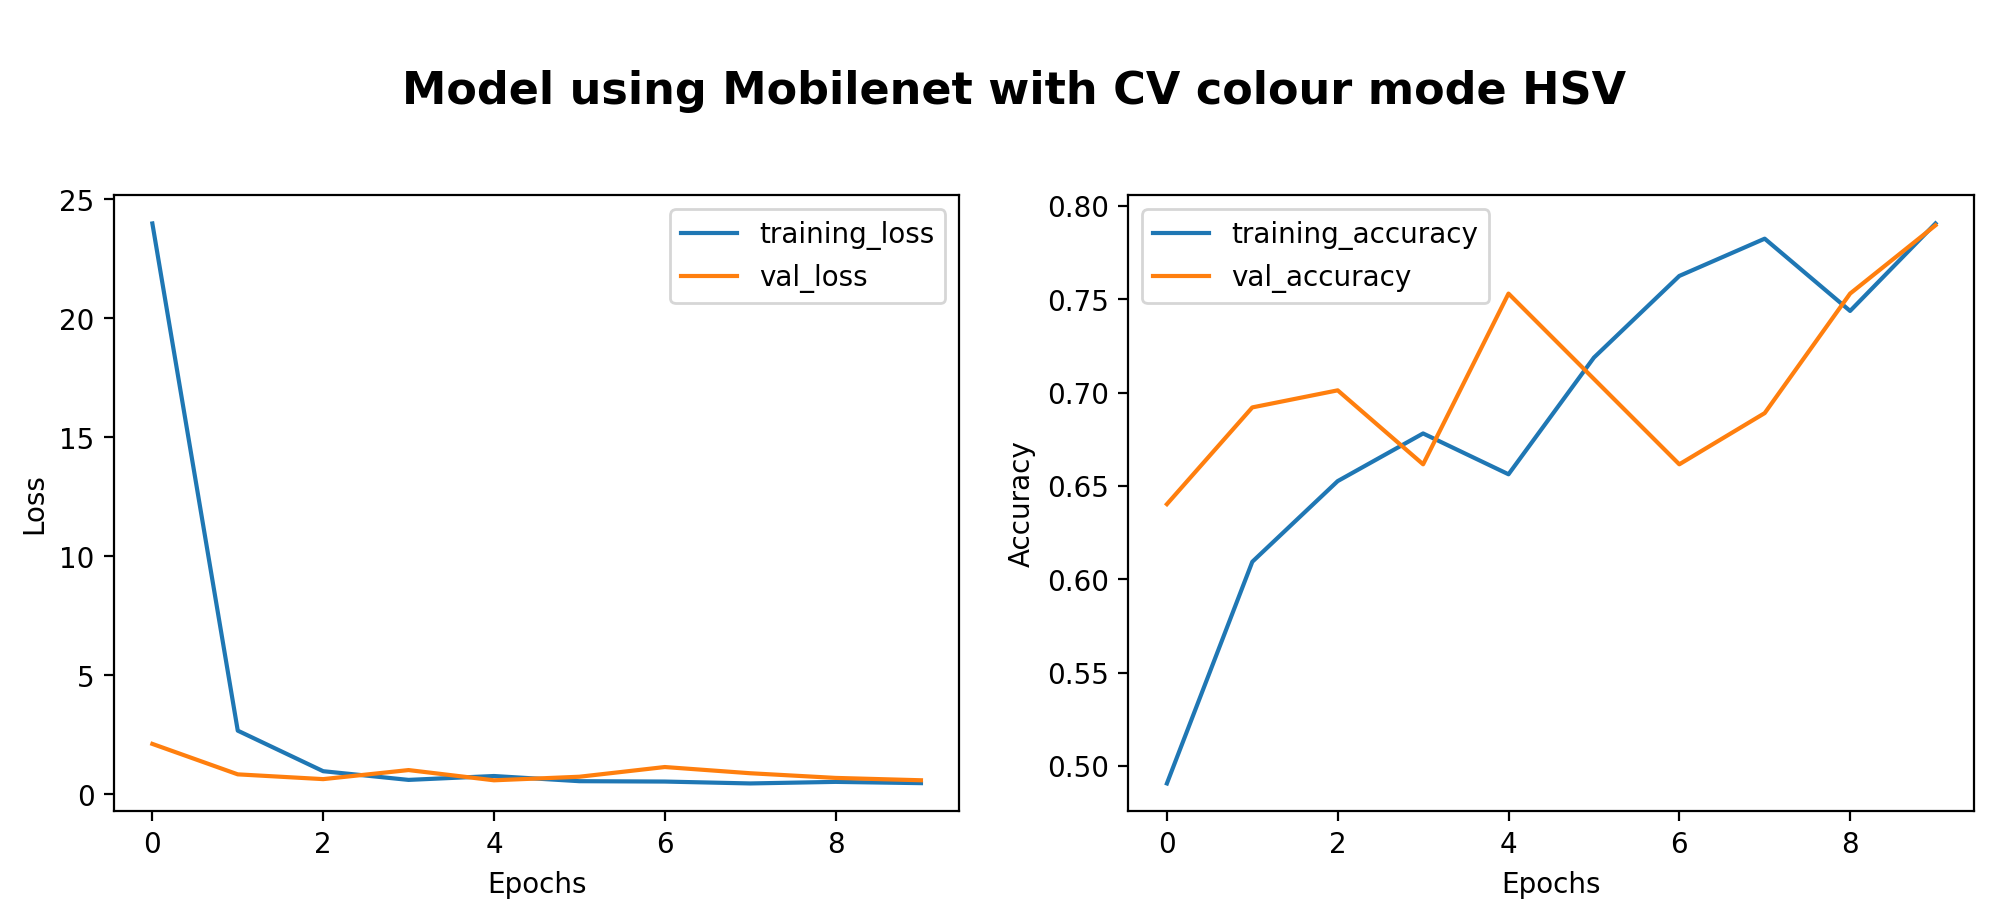


Model using VGG with CV colour mode GRAY

Found 1588 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 8 images belonging to 1 classes.
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 3.8964 - accuracy: 0.5094
Epoch 1: val_accuracy improved from -inf to 0.58232, saving model to D:/Applied AI (save)\model_VGGGRAY.h5
10/10 [==============================] - 8s 831ms/step - loss: 3.8964 - accuracy: 0.5094 - val_loss: 1.0434 - val_accuracy: 0.5823
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.8557 - accuracy: 0.5188
Epoch 2: val_accuracy improved from 0.58232 to 0.74695, saving model to D:/Applied AI (save)\model_VGGGRAY.h5
10/10 [==============================] - 8s 857ms/step - loss: 0.8557 - accuracy: 0.5188 - val_loss: 0.5805 - val_accuracy: 0.7470
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6334 - accuracy: 0.6500
Epoch 3: val_accuracy did not improve from 0.74695
10/10 [================

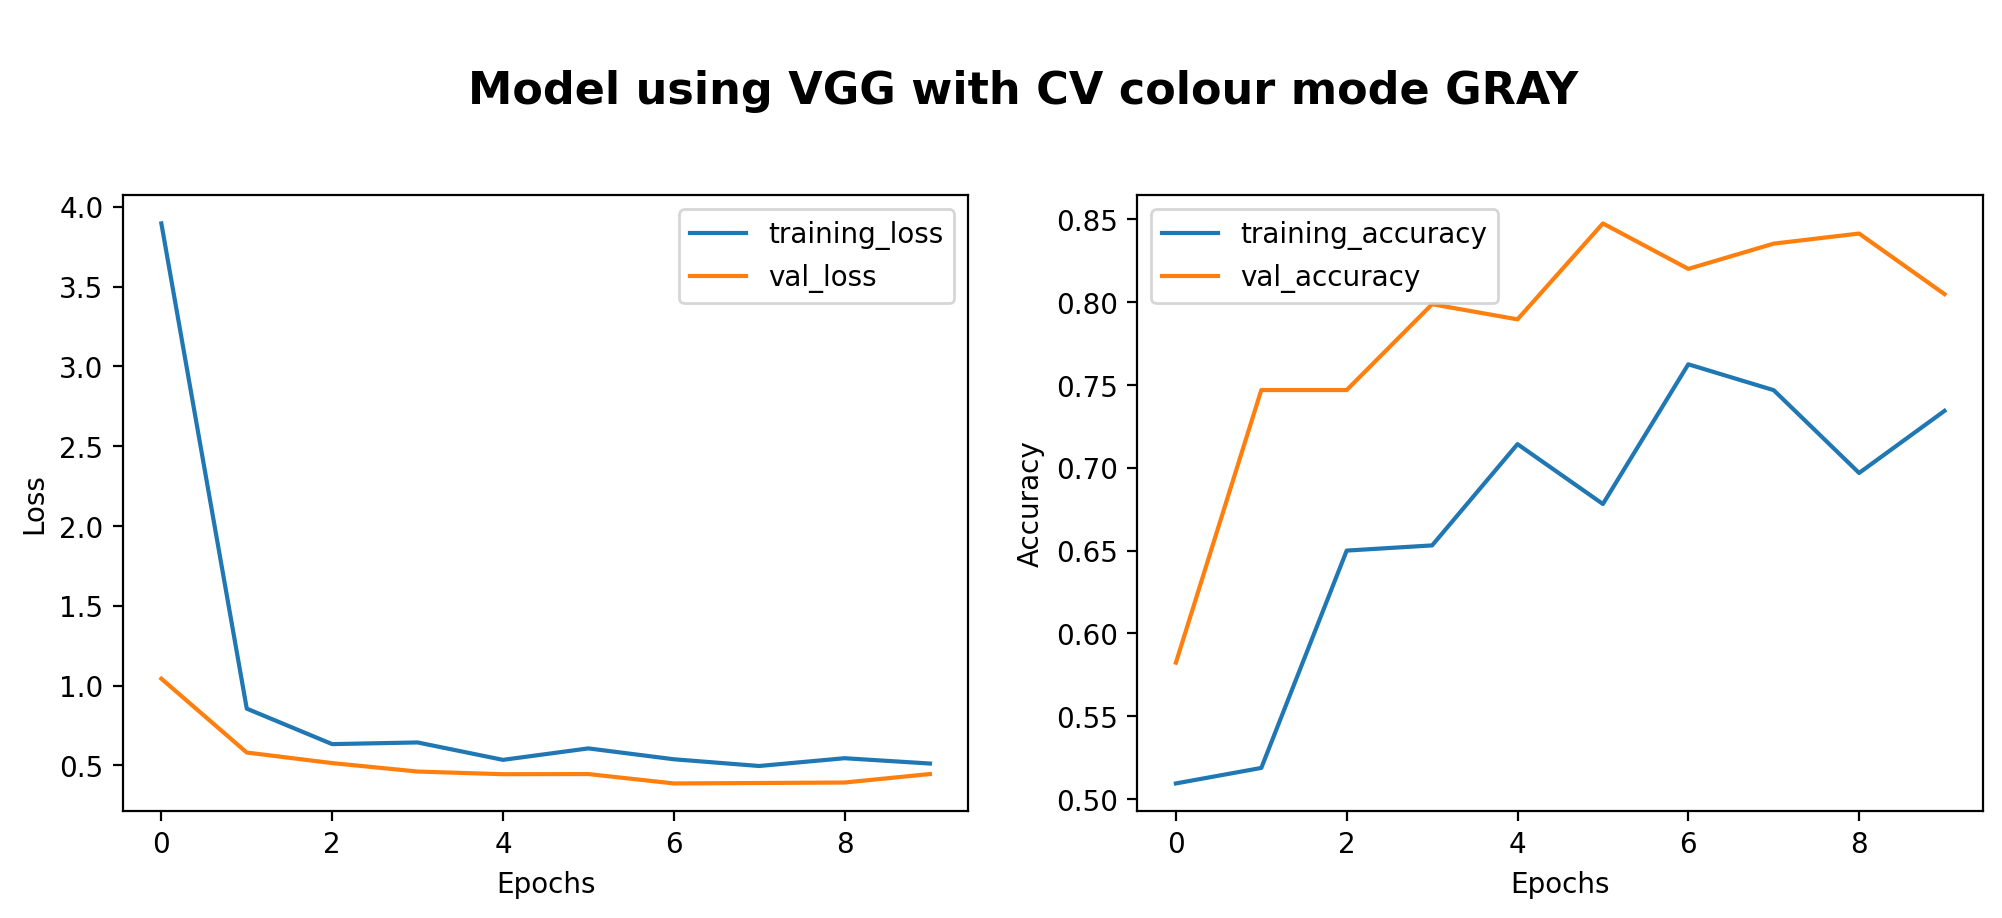


Model using ResNet with CV colour mode GRAY

Found 1588 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 8 images belonging to 1 classes.
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 9.8455 - accuracy: 0.4938 
Epoch 1: val_accuracy improved from -inf to 0.41768, saving model to D:/Applied AI (save)\model_ResNetGRAY.h5
10/10 [==============================] - 17s 2s/step - loss: 9.8455 - accuracy: 0.4938 - val_loss: 3.9850 - val_accuracy: 0.4177
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.6554 - accuracy: 0.5000
Epoch 2: val_accuracy did not improve from 0.41768
10/10 [==============================] - 6s 621ms/step - loss: 1.6554 - accuracy: 0.5000 - val_loss: 0.8597 - val_accuracy: 0.4177
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.5031
Epoch 3: val_accuracy improved from 0.41768 to 0.58232, saving model to D:/Applied AI (save)\model_ResNetGRAY.h5
10/10 [========

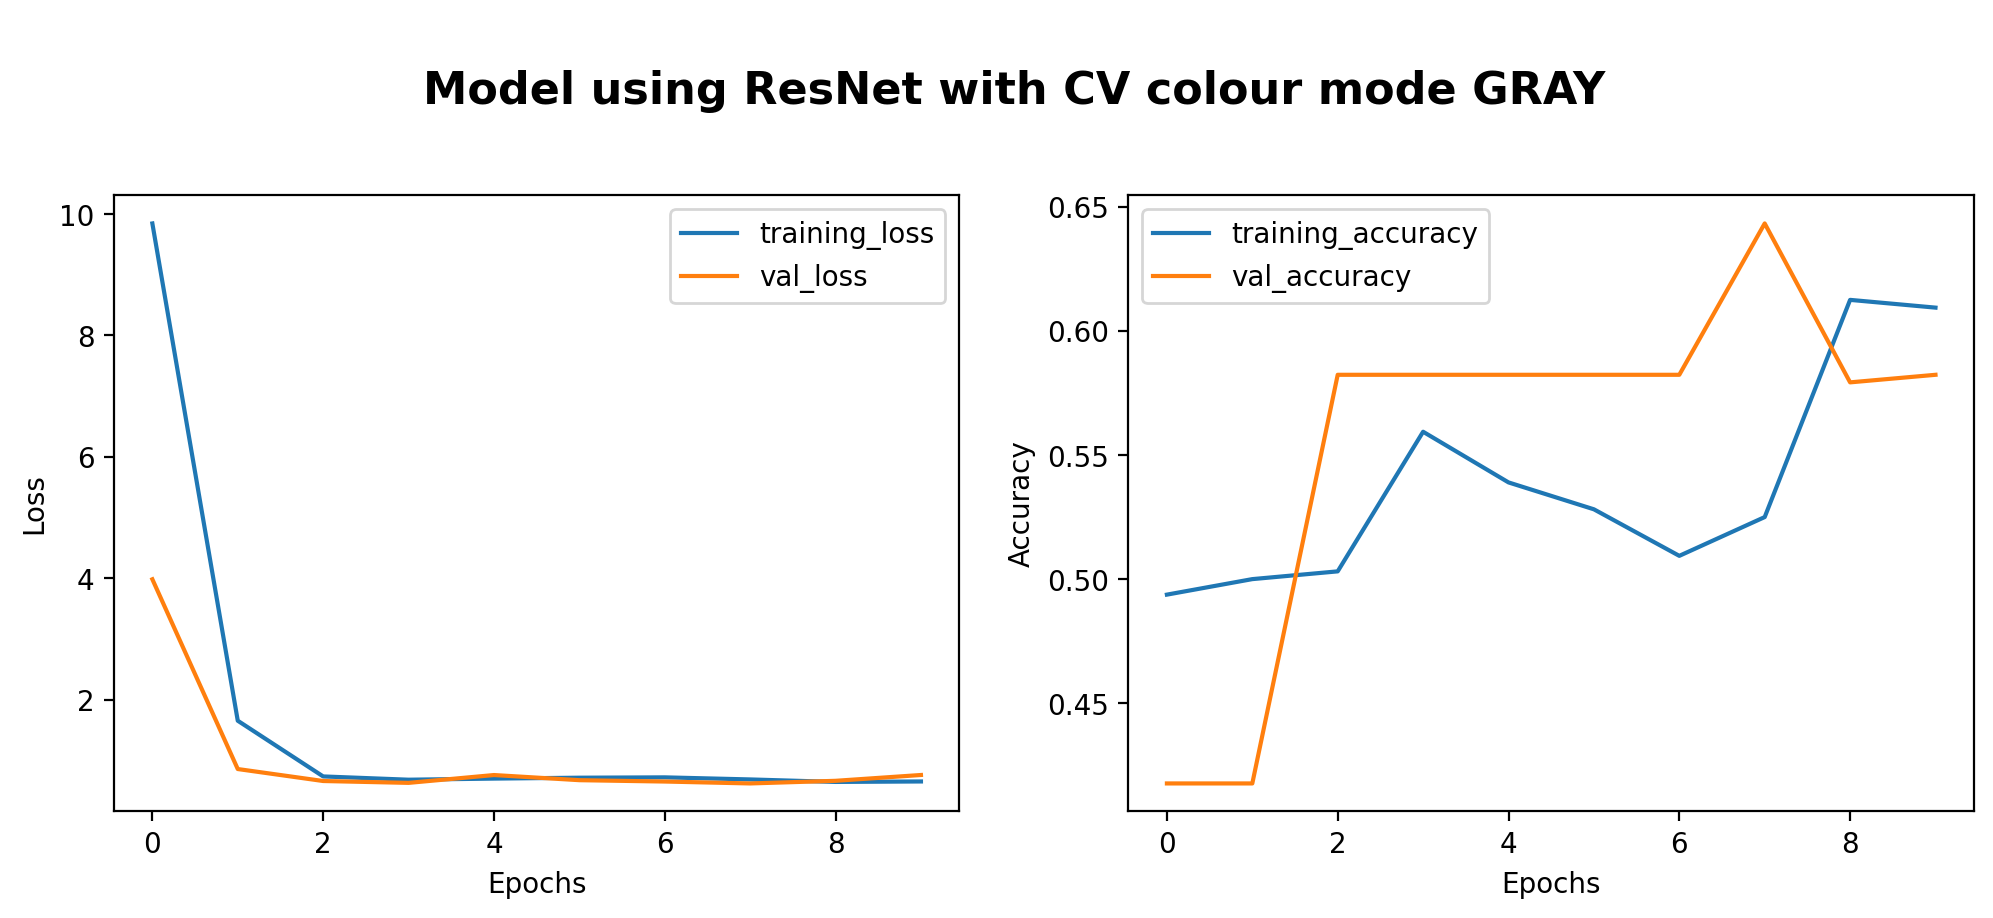


Model using Inception with CV colour mode GRAY

Found 1588 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 8 images belonging to 1 classes.
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 29.8710 - accuracy: 0.5219
Epoch 1: val_accuracy improved from -inf to 0.65854, saving model to D:/Applied AI (save)\model_InceptionGRAY.h5
10/10 [==============================] - 12s 1s/step - loss: 29.8710 - accuracy: 0.5219 - val_loss: 1.5139 - val_accuracy: 0.6585
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.4135 - accuracy: 0.6006
Epoch 2: val_accuracy did not improve from 0.65854
10/10 [==============================] - 7s 704ms/step - loss: 1.4135 - accuracy: 0.6006 - val_loss: 1.0841 - val_accuracy: 0.6067
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 1.5278 - accuracy: 0.6234
Epoch 3: val_accuracy did not improve from 0.65854
10/10 [==============================] - 7s 693ms/step - loss: 1.5278 

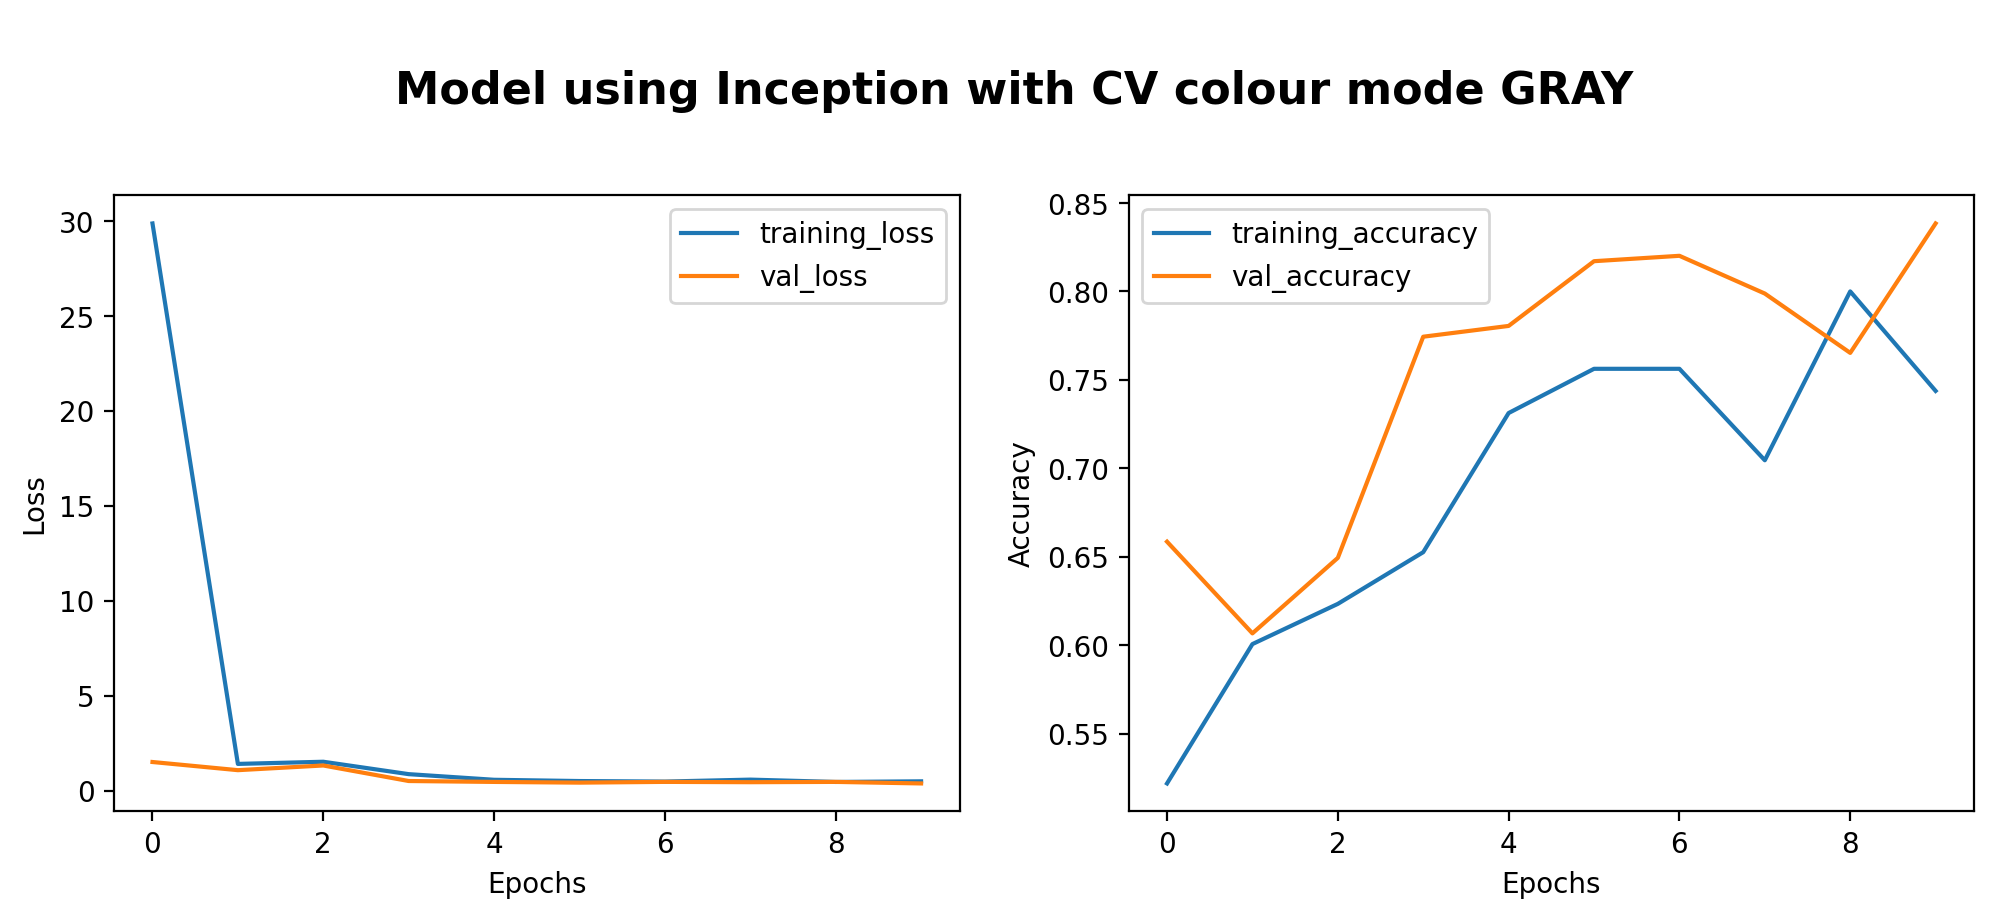


Model using Mobilenet with CV colour mode GRAY

Found 1588 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 8 images belonging to 1 classes.
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 34.9339 - accuracy: 0.5188
Epoch 1: val_accuracy improved from -inf to 0.65244, saving model to D:/Applied AI (save)\model_MobilenetGRAY.h5
10/10 [==============================] - 14s 1s/step - loss: 34.9339 - accuracy: 0.5188 - val_loss: 1.2186 - val_accuracy: 0.6524
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 2.2448 - accuracy: 0.5938
Epoch 2: val_accuracy improved from 0.65244 to 0.75305, saving model to D:/Applied AI (save)\model_MobilenetGRAY.h5
10/10 [==============================] - 11s 1s/step - loss: 2.2448 - accuracy: 0.5938 - val_loss: 0.8435 - val_accuracy: 0.7530
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 1.3584 - accuracy: 0.6000
Epoch 3: val_accuracy improved from 0.75305 to 0.83537, sa

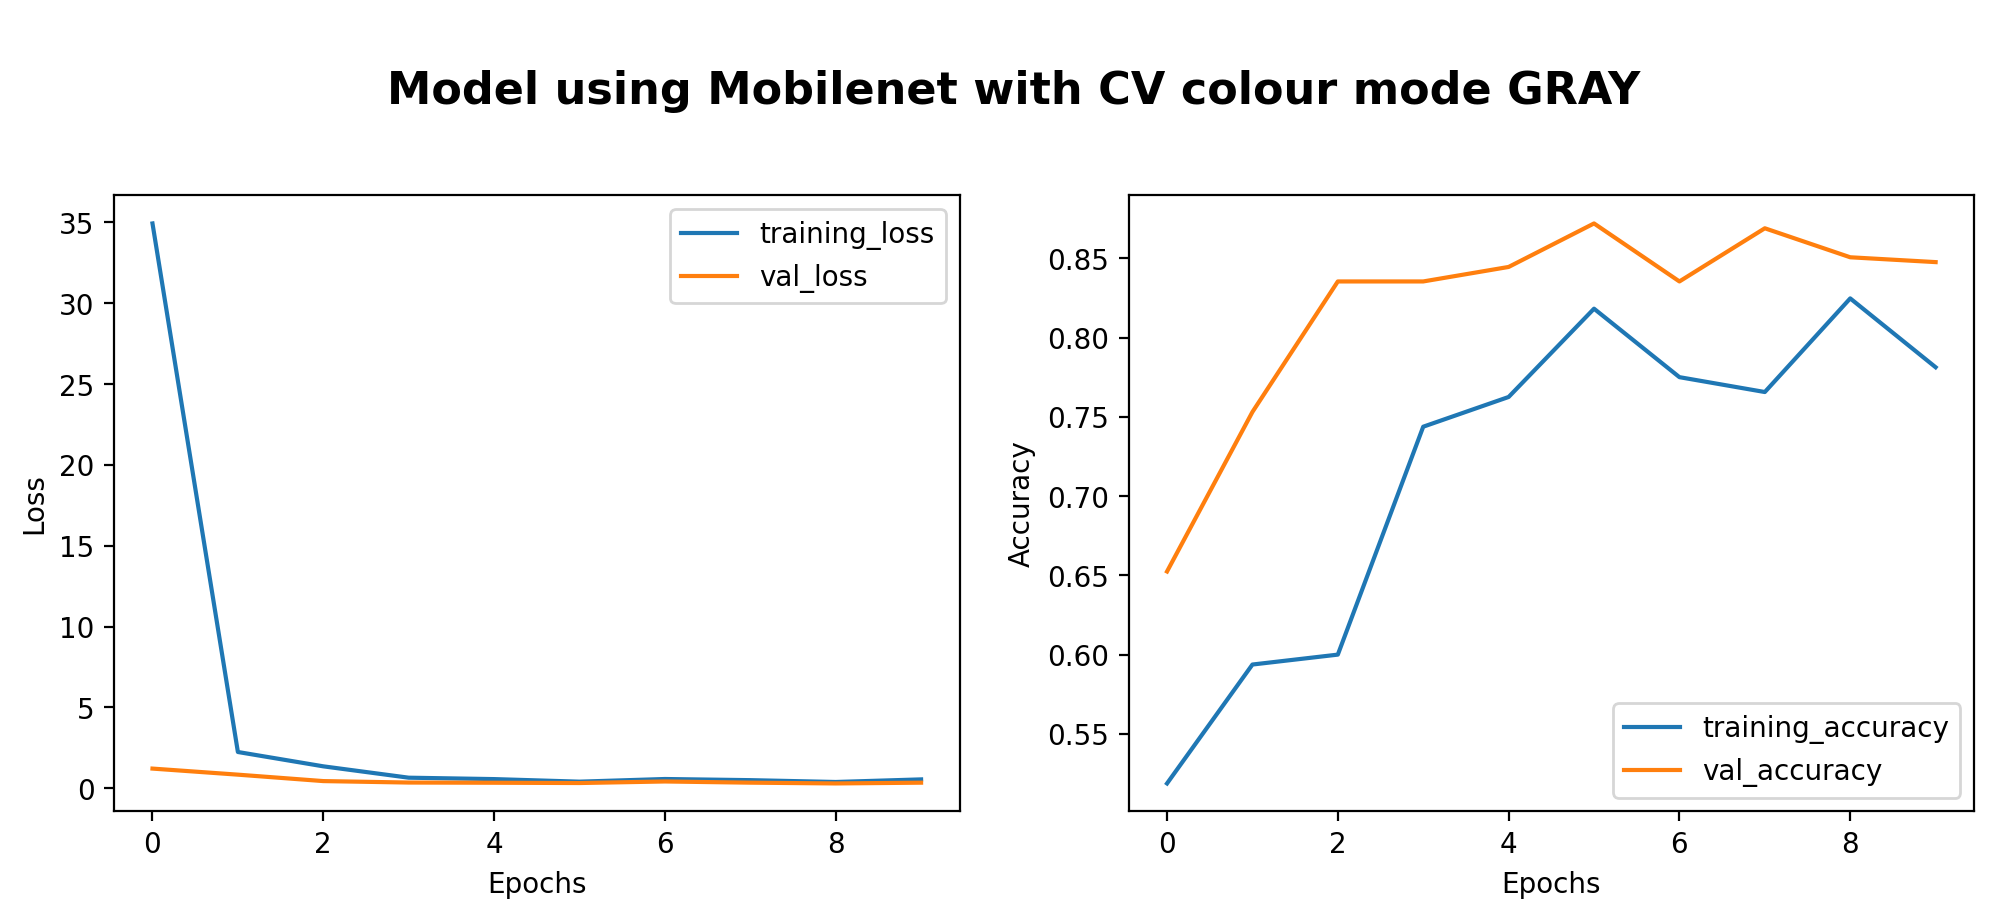

In [9]:
train_generator, validation_generator, test_generator,train_datagen, test_datagen = ComV_Pmodel(modes, pmodel)

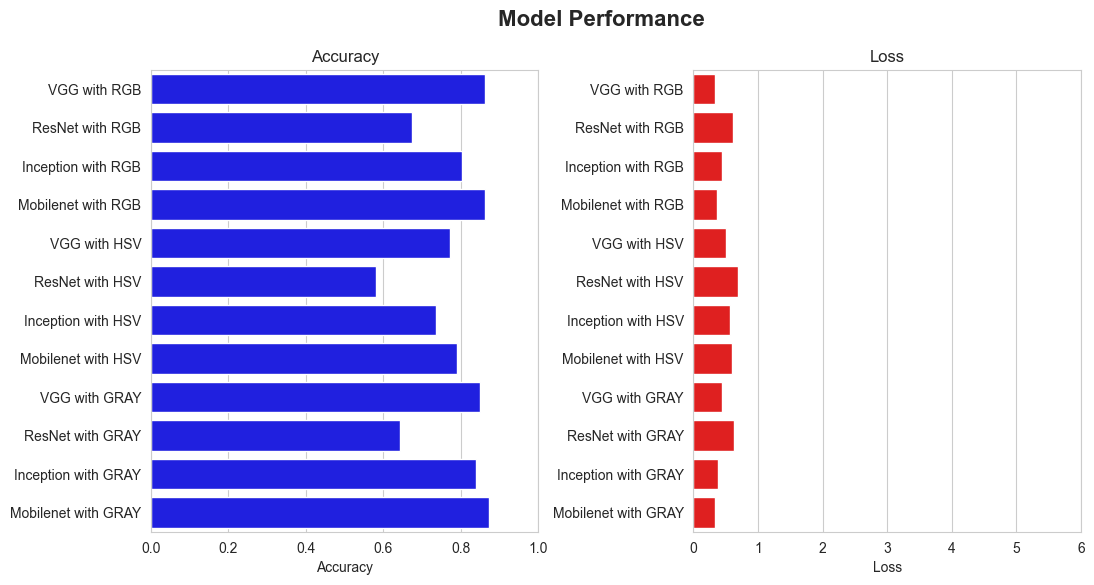

In [10]:
# Let's visualize and see the performance for each model.

pcv_dict = dict(
    Models = name_data,
    Accuracy = accuracy_data, Loss = loss_data,
    Parameters = params_count, Path = directory)


pcv_df = pd.DataFrame.from_dict(pcv_dict)

sns.set_style('whitegrid')
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the accuracy on the left axis
sns.barplot(x='Accuracy', y='Models', data=pcv_df, ax=axs[0], color='blue')
axs[0].set(xlabel='Accuracy', ylabel='', xlim=(0, 1), title='Accuracy')

# Plot the loss on the right axis
sns.barplot(x='Loss', y='Models', data=pcv_df, ax=axs[1], color='red')
axs[1].set(xlabel='Loss', ylabel='', xlim=(0, 6), title='Loss')

# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.4)
 
# Add a title
fig.suptitle('Model Performance', fontsize=16, fontweight='bold')

plt.show()

In [11]:
# Let's scale the acc and loss in a new column to enable us know the best rated performance.  

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


to_scale = pcv_df[['Accuracy', 'Loss']]

scaler.fit(to_scale)
           
performance_scaled = scaler.transform(to_scale)

scaled = pd.DataFrame(performance_scaled, columns = to_scale.columns)

pcv_df['Rating'] = round((scaled['Accuracy'] + (1-scaled['Loss'])) /2,2)*100

pcv_df

Models  Accuracy   Loss  Parameters  \
0          VGG with RGB     0.863  0.340    35694402   
1       ResNet with RGB     0.674  0.616   132647810   
2    Inception with RGB     0.802  0.435    63754018   
3    Mobilenet with RGB     0.863  0.357    71996482   
4          VGG with HSV     0.771  0.508    35694402   
5       ResNet with HSV     0.582  0.684   132647810   
6    Inception with HSV     0.735  0.559    63754018   
7    Mobilenet with HSV     0.790  0.595    71996482   
8         VGG with GRAY     0.848  0.446    35694402   
9      ResNet with GRAY     0.643  0.622   132647810   
10  Inception with GRAY     0.838  0.385    63754018   
11  Mobilenet with GRAY     0.872  0.326    71996482   

                                           Path  Rating  
0          D:/Applied AI (save)/model_VGGRGB.h5    96.0  
1       D:/Applied AI (save)/model_ResNetRGB.h5    25.0  
2    D:/Applied AI (save)/model_InceptionRGB.h5    73.0  
3    D:/Applied AI (save)/model_MobilenetRGB.h5    94.0  
4          D:/Applied AI (save)/model_VGGHSV.h5    57.0  
5       D:/Applied AI (save)/model_ResNetHSV.h5     0.0  
6    D:/Applied AI (save)/model_InceptionHSV.h5    44.0  
7    D:/Applied AI (save)/model_MobilenetHSV.h5    48.0  
8         D:/Applied AI (save)/model_VGGGRAY.h5    79.0  
9      D:/Applied AI (save)/model_ResNetGRAY.h5    19.0  
10  D:/Applied AI (save)/model_InceptionGRAY.h5    86.0  
11  D:/Applied AI (save)/model_MobilenetGRAY.h5   100.0

Models  Accuracy   Loss  Parameters  \
0  Mobilenet with GRAY     0.872  0.326    71996482   
1         VGG with RGB     0.863  0.340    35694402   
2   Mobilenet with RGB     0.863  0.357    71996482   
3  Inception with GRAY     0.838  0.385    63754018   
4        VGG with GRAY     0.848  0.446    35694402   

                                          Path  Rating  
0  D:/Applied AI (save)/model_MobilenetGRAY.h5   100.0  
1         D:/Applied AI (save)/model_VGGRGB.h5    96.0  
2   D:/Applied AI (save)/model_MobilenetRGB.h5    94.0  
3  D:/Applied AI (save)/model_InceptionGRAY.h5    86.0  
4        D:/Applied AI (save)/model_VGGGRAY.h5    79.0

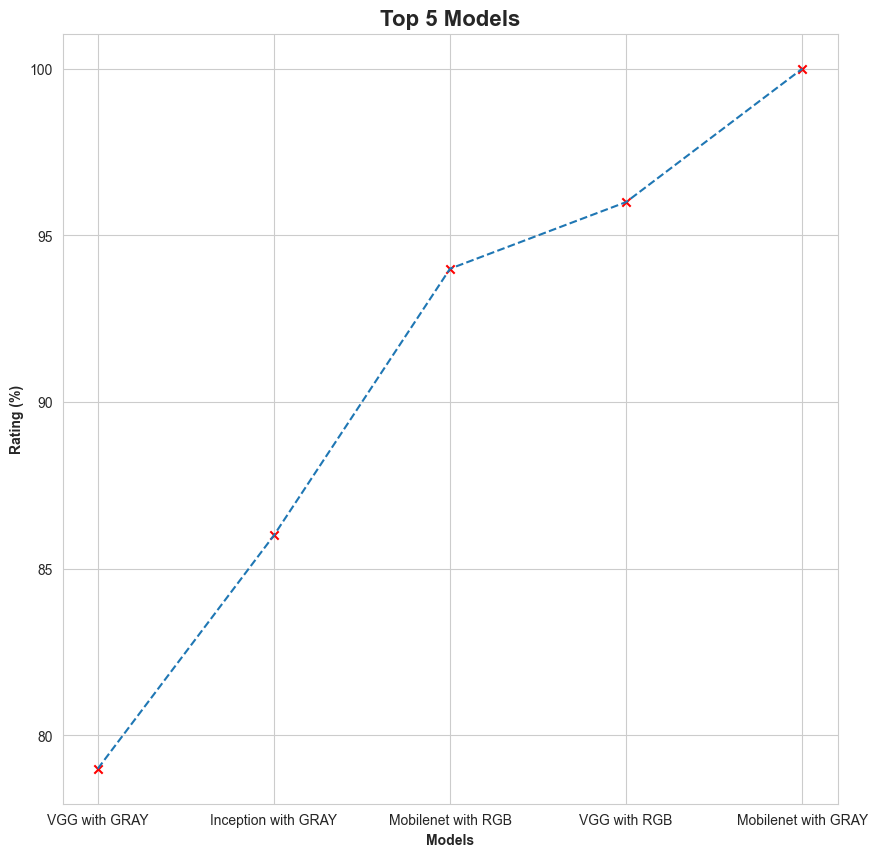

In [12]:
# Let's create a function that returns the best model performance 

def best_models(n):
    
    """
    This function returns the nth best performing model.
    
    """
    
    best = pcv_df.nlargest(n, 'Rating')
    best_sort = best.sort_values(by='Rating', ascending=True)
    
    ratings = best_sort['Rating']
    model = best_sort['Models']
    
    plt.plot(model, ratings, linestyle='--')
    plt.scatter(model, ratings, marker= 'x', c ='r')
    
    plt.xlabel('Models', fontweight='bold')
    plt.ylabel('Rating (%)', fontweight='bold')
    plt.title(f'Top {n} Models', fontsize=16, fontweight='bold')
    
    best.reset_index(inplace=True,drop=True)
    
    return best

best = best_models(5)

best

### Hyperparameter tuning
For us to simplify the objective to tune our model, it will be neccessary to create a function that takes in sevaral parameter which will aid us to seamlessly tune a selected model.

In [13]:
def hp_tuning(p_model, cv_mode, path_name):
    
    train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    preprocessing_function= preprocess_io(mode= cv_mode))
    
    
    def hp_func(hp):

        a = p_model
        x = layers.Flatten()(a.output)
        x = layers.Dense(units = hp.Int('unit_1', min_value = 32, max_value = 4000, step = 128), activation ='relu')(x)
        x = layers.Dense(units = hp.Int('unit_2', min_value = 32, max_value = 4000, step = 128), activation ='relu')(x)
        x = layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.0, 0.1, 0.2, 0.3, 0.4]))(x)

        x = layers.Dense(2, activation='softmax')(x)

        model = Model(inputs = a.input, outputs = x)

        model.compile(optimizer=Adam(hp.Choice('learning rate',values = [1e-2, 1e-3, 1e-4])), 
                      loss='sparse_categorical_crossentropy', metrics='accuracy')   

        return model
    
    tuned_model = kt.Hyperband(hp_func,objective= 'val_accuracy', max_epochs = 10, factor= 3,
                         directory = 'D:/Applied AI (save)/', project_name = path_name)
    
    tuned_model.search(train_generator, epochs=10,validation_data= validation_generator)
    best = tuned_model.get_best_hyperparameters(num_trials=1)[0]
    model = hp_func(best)
    
    
    return model

In [14]:
model_gray_mn = hp_tuning(mobilenet, 'GRAY', 'GRAY_mobileNet')
model_gray_mn.summary(show_trainable = True)

Trial 30 Complete [00h 04m 05s]
val_accuracy: 0.5853658318519592

Best val_accuracy So Far: 0.9085366129875183
Total elapsed time: 00h 52m 33s
INFO:tensorflow:Oracle triggered exit
Model: "model_1"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_4[0][0]']                N          
                                                                                                             
 bn_Conv1 (BatchNormalization)  

                                                                  'block_2_project_BN[0][0]']                
                                                                                                             
 block_3_expand (Conv2D)        (None, 38, 38, 144)  3456        ['block_2_add[0][0]']            N          
                                                                                                             
 block_3_expand_BN (BatchNormal  (None, 38, 38, 144)  576        ['block_3_expand[0][0]']         N          
 ization)                                                                                                    
                                                                                                             
 block_3_expand_relu (ReLU)     (None, 38, 38, 144)  0           ['block_3_expand_BN[0][0]']      N          
                                                                                                             
 block_3_p

 block_6_expand_BN (BatchNormal  (None, 19, 19, 192)  768        ['block_6_expand[0][0]']         N          
 ization)                                                                                                    
                                                                                                             
 block_6_expand_relu (ReLU)     (None, 19, 19, 192)  0           ['block_6_expand_BN[0][0]']      N          
                                                                                                             
 block_6_pad (ZeroPadding2D)    (None, 21, 21, 192)  0           ['block_6_expand_relu[0][0]']    N          
                                                                                                             
 block_6_depthwise (DepthwiseCo  (None, 10, 10, 192)  1728       ['block_6_pad[0][0]']            N          
 nv2D)                                                                                                       
          

                                                                                                             
 block_9_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_9_expand_relu[0][0]']    N          
 nv2D)                                                                                                       
                                                                                                             
 block_9_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_9_depthwise[0][0]']      N          
 malization)                                                                                                 
                                                                                                             
 block_9_depthwise_relu (ReLU)  (None, 10, 10, 384)  0           ['block_9_depthwise_BN[0][0]']   N          
                                                                                                             
 block_9_p

                                                                                                             
 block_12_depthwise_relu (ReLU)  (None, 10, 10, 576)  0          ['block_12_depthwise_BN[0][0]']  N          
                                                                                                             
 block_12_project (Conv2D)      (None, 10, 10, 96)   55296       ['block_12_depthwise_relu[0][0]  N          
                                                                 ']                                          
                                                                                                             
 block_12_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_12_project[0][0]']       N          
 alization)                                                                                                  
                                                                                                             
 block_12_

                                                                 ']                                          
                                                                                                             
 block_15_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_15_project[0][0]']       N          
 alization)                                                                                                  
                                                                                                             
 block_15_add (Add)             (None, 5, 5, 160)    0           ['block_14_add[0][0]',           N          
                                                                  'block_15_project_BN[0][0]']               
                                                                                                             
 block_16_expand (Conv2D)       (None, 5, 5, 960)    153600      ['block_15_add[0][0]']           N          
          

In [15]:
model_rgb_vgg = hp_tuning(vgg, 'RGB', 'RGB_VGG')
model_rgb_vgg.summary(show_trainable = True)

Trial 30 Complete [00h 03m 56s]
val_accuracy: 0.8810975551605225

Best val_accuracy So Far: 0.8902438879013062
Total elapsed time: 00h 49m 26s
INFO:tensorflow:Oracle triggered exit
Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      N          
                                                                            
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     N          
                                                                            
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         N          
                                                                            
 block2_conv1 (Conv2D)       (No

In [16]:

def tuned_model(model, cv_colour, save_name):
    
    """
    This function will be used to run and save
    our model.It takes in three argument, the model, 
    the cv colour model and propose save name.
    
    """
    
    train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    preprocessing_function= preprocess_io(mode= cv_colour))
    
    
    #for i in model.layers:
        
        #layer.trainable = False
    

    mc = ModelCheckpoint(filepath=f'D:/Applied AI (save)/{save_name}.h5',
                                     monitor='val_accuracy',
                                     verbose=1,
                                     save_best_only=True)

    es = EarlyStopping(monitor='val_accuracy',
                       min_delta=0.01,
                       patience=10,
                       verbose=1)
    
    cb = [mc,es]
    
    history = model.fit(train_generator, epochs = 10, validation_data = validation_generator, callbacks = cb)
    
    history_df = pd.DataFrame(history.history)
    
    fig, axs = plt.subplots(ncols=2, figsize=(12,4), dpi=200)

    # Plot for loss
    axs[0].plot(history_df['loss'], label='training_loss')
    axs[0].plot(history_df['val_loss'], label='val_loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()


    # Plot for accuracy
    axs[1].plot(history_df['accuracy'], label='training_accuracy')
    axs[1].plot(history_df['val_accuracy'], label='val_accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Set title
    fig.suptitle(f"\n{save_name} Model Performance\n", fontsize=16, fontweight='bold', y=1.1)

    plt.show()
    
    
    return history


Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.5853 - accuracy: 0.6952
Epoch 1: val_accuracy improved from -inf to 0.85671, saving model to D:/Applied AI (save)\Tuned_GRAY_mobileNet.h5
50/50 [==============================] - 26s 492ms/step - loss: 0.5853 - accuracy: 0.6952 - val_loss: 0.3770 - val_accuracy: 0.8567
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.4554 - accuracy: 0.7777
Epoch 2: val_accuracy improved from 0.85671 to 0.88720, saving model to D:/Applied AI (save)\Tuned_GRAY_mobileNet.h5
50/50 [==============================] - 24s 468ms/step - loss: 0.4554 - accuracy: 0.7777 - val_loss: 0.3168 - val_accuracy: 0.8872
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.3792 - accuracy: 0.8344
Epoch 3: val_accuracy did not improve from 0.88720
50/50 [==============================] - 23s 465ms/step - loss: 0.3792 - accuracy: 0.8344 - val_loss: 0.2974 - val_accuracy: 0.8750
Epoch 4/10
50/50 [======================

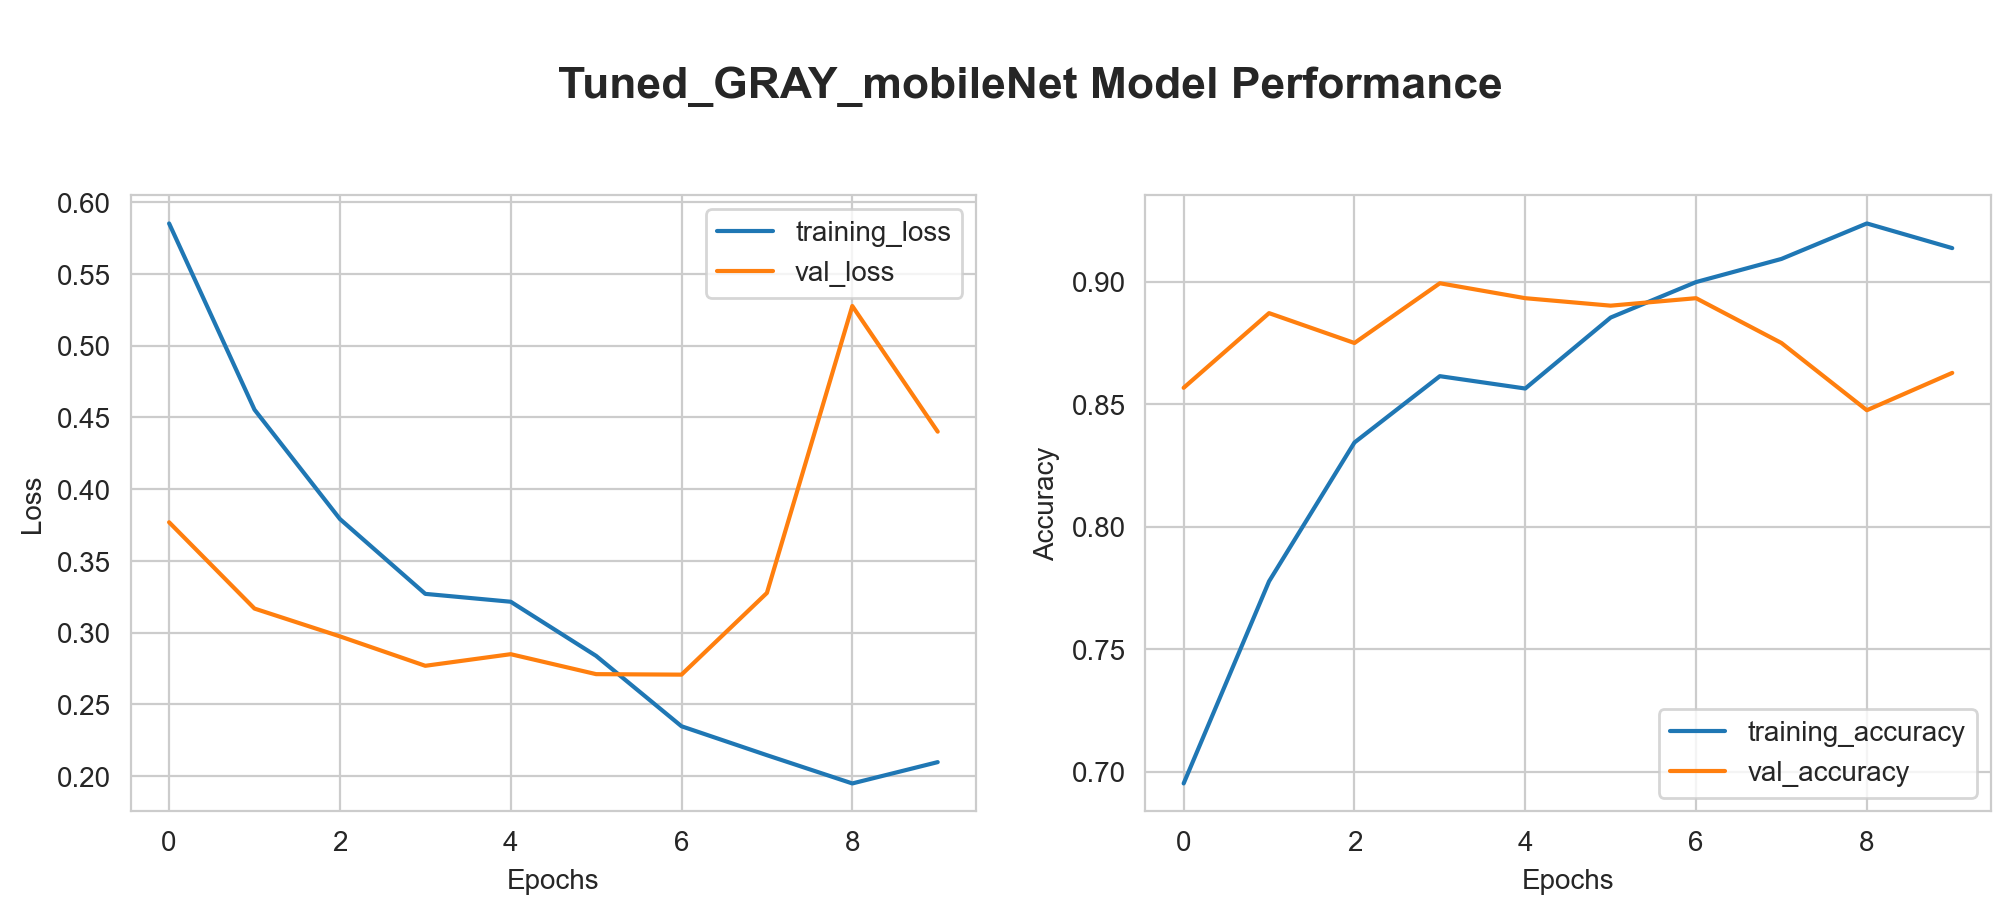

In [17]:
tuned_model(model_gray_mn, 'GRAY', 'Tuned_GRAY_mobileNet') 
model_tuned_1 = load_model(f'D:/Applied AI (save)/Tuned_GRAY_mobileNet.h5')

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.6464 - accuracy: 0.6656
Epoch 1: val_accuracy improved from -inf to 0.82622, saving model to D:/Applied AI (save)\Tuned_RGB_VGG.h5
50/50 [==============================] - 26s 510ms/step - loss: 0.6464 - accuracy: 0.6656 - val_loss: 0.4049 - val_accuracy: 0.8262
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.5468 - accuracy: 0.7261
Epoch 2: val_accuracy improved from 0.82622 to 0.85671, saving model to D:/Applied AI (save)\Tuned_RGB_VGG.h5
50/50 [==============================] - 25s 492ms/step - loss: 0.5468 - accuracy: 0.7261 - val_loss: 0.3515 - val_accuracy: 0.8567
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.4700 - accuracy: 0.7727
Epoch 3: val_accuracy improved from 0.85671 to 0.85976, saving model to D:/Applied AI (save)\Tuned_RGB_VGG.h5
50/50 [==============================] - 25s 491ms/step - loss: 0.4700 - accuracy: 0.7727 - val_loss: 0.3488 - val_accuracy: 0.

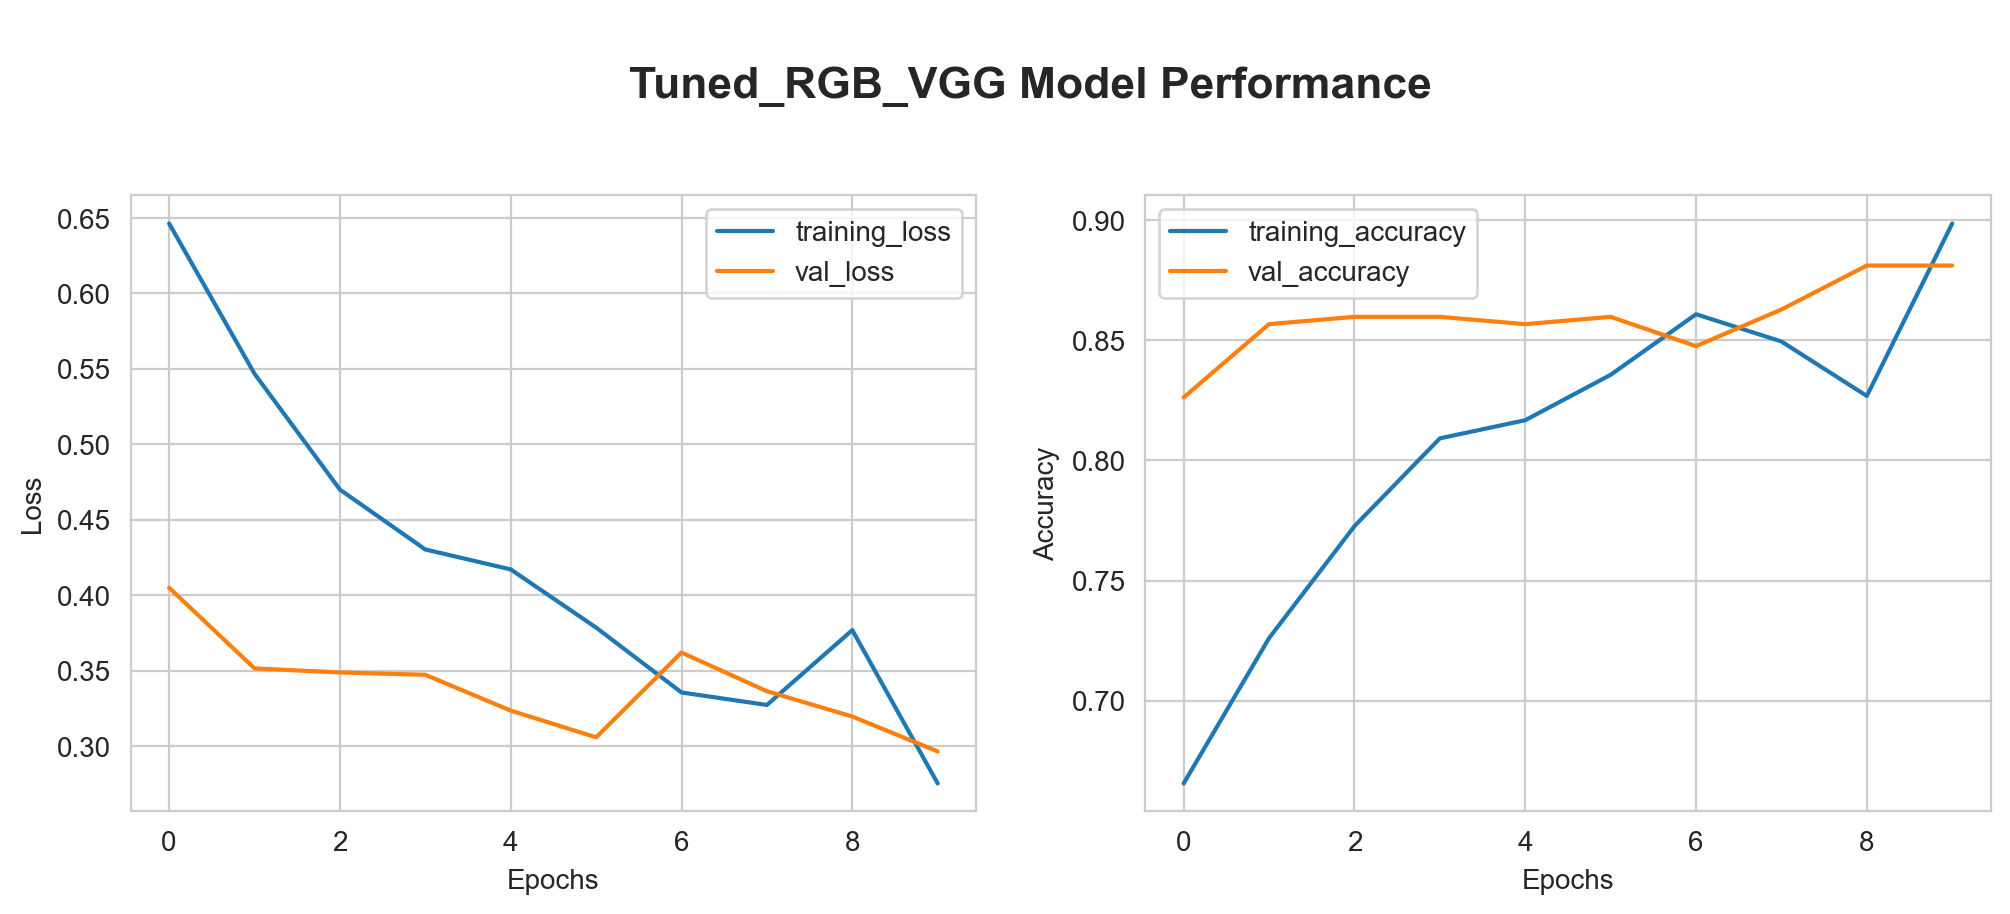

In [18]:
tuned_model(model_rgb_vgg, 'RGB', 'Tuned_RGB_VGG') 
model_tuned_2 = load_model(f'D:/Applied AI (save)/Tuned_RGB_VGG.h5')

In [19]:
# Confusion matrix plot function 

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
     
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


 Classification Report

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       191
           1       0.89      0.87      0.88       137

    accuracy                           0.90       328
   macro avg       0.90      0.90      0.90       328
weighted avg       0.90      0.90      0.90       328



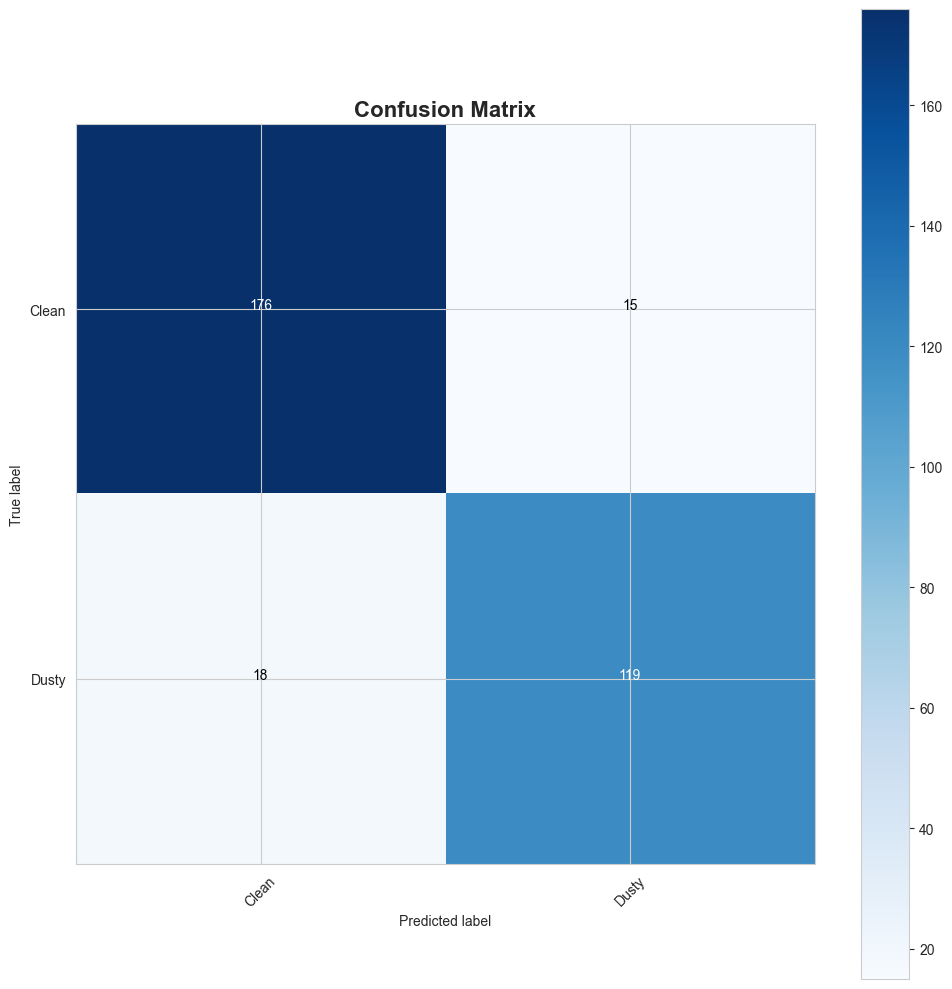

C:\Program Files\Python310\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



 Classification Report

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       191
           1       0.81      0.93      0.87       137

    accuracy                           0.88       328
   macro avg       0.88      0.89      0.88       328
weighted avg       0.89      0.88      0.88       328



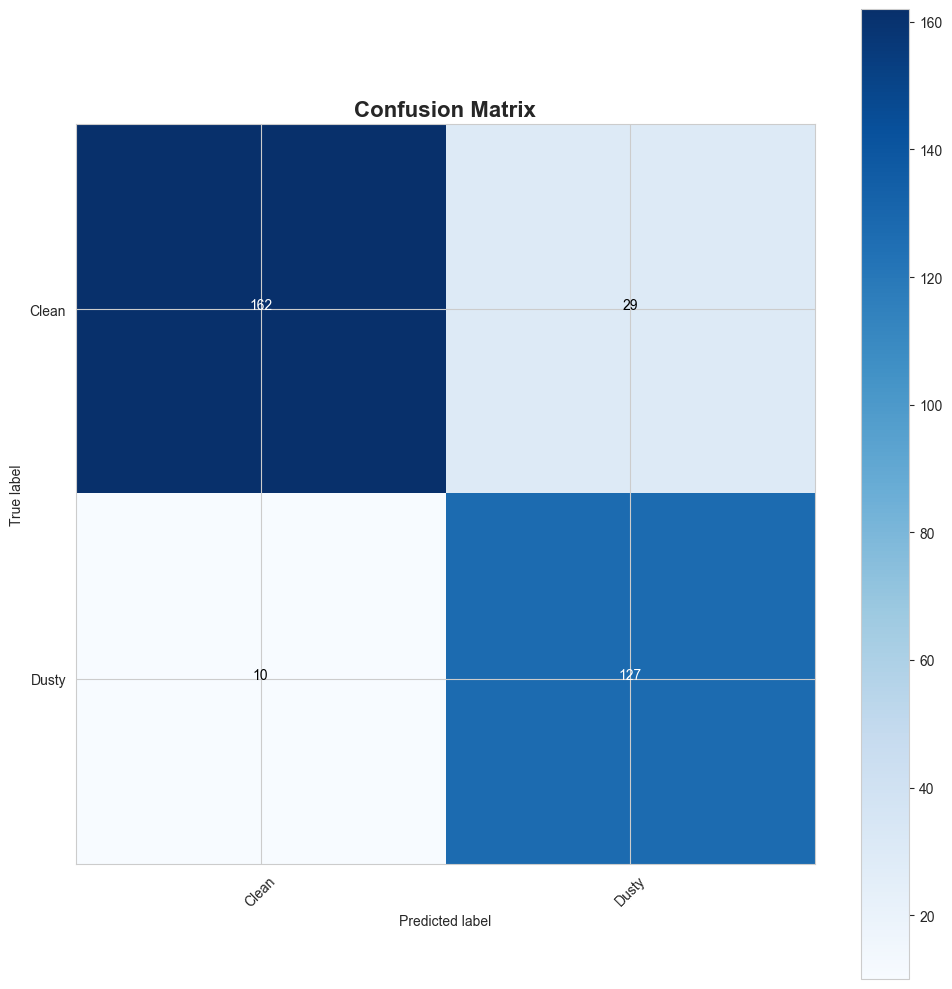

In [20]:
# Let's view the classification report and the confusion matrix for the turned models.

for i in [model_tuned_1, model_tuned_2]:
    
    labels = list(train_generator.class_indices.keys())
    
    predictions = i.predict(x=validation_generator, verbose=0)

    predictions = np.argmax(predictions, axis=1)
    
    #predictions = (predictions > 0.5).astype(int)

    print(f"\n Classification Report\n")

    print(classification_report(validation_generator.classes, predictions))

    cm =confusion_matrix(validation_generator.classes, predictions)
    plot_confusion_matrix(cm=cm, classes=labels)
    plt.title(f'Confusion Matrix', fontsize=16, fontweight='bold')
    plt.show()

### Testing with new data images 

In [21]:
def test_img(modelx):
    
    """
    This function is used to test our model on new dataset.
    This function takes in a single parameter which is the model.
    
    """
    
    labels = list(train_generator.class_indices.keys())
    images = next(test_generator)
    
    for idx, img in enumerate(images,1):
        plt.subplot(4, 2, idx)
        pred = modelx.predict(np.array([img]))
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(f'prediction:{labels[np.argmax(pred)]}')
        plt.grid(visible=None)
        plt.xticks([])
        plt.yticks([])   
        

1/1 [==============================] - 0s 24ms/step


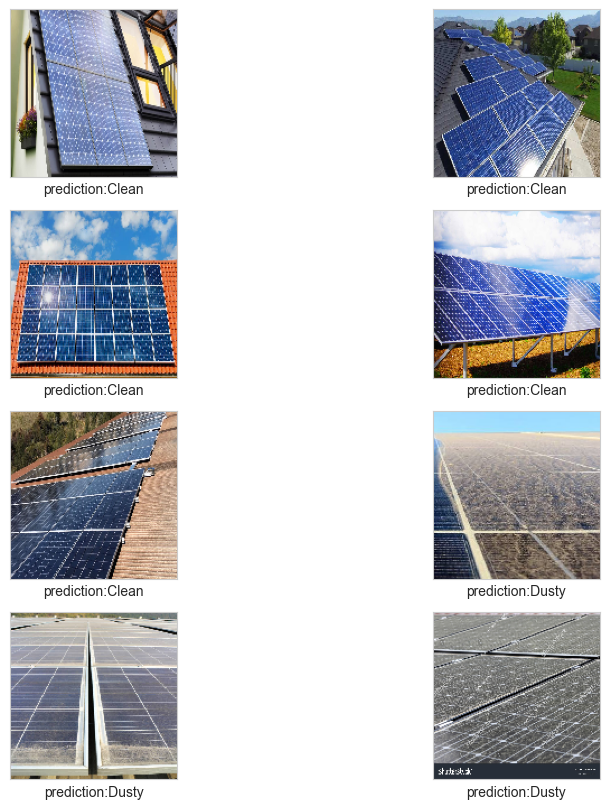

In [22]:
test_img(model_tuned_1) 

1/1 [==============================] - 0s 0s/step


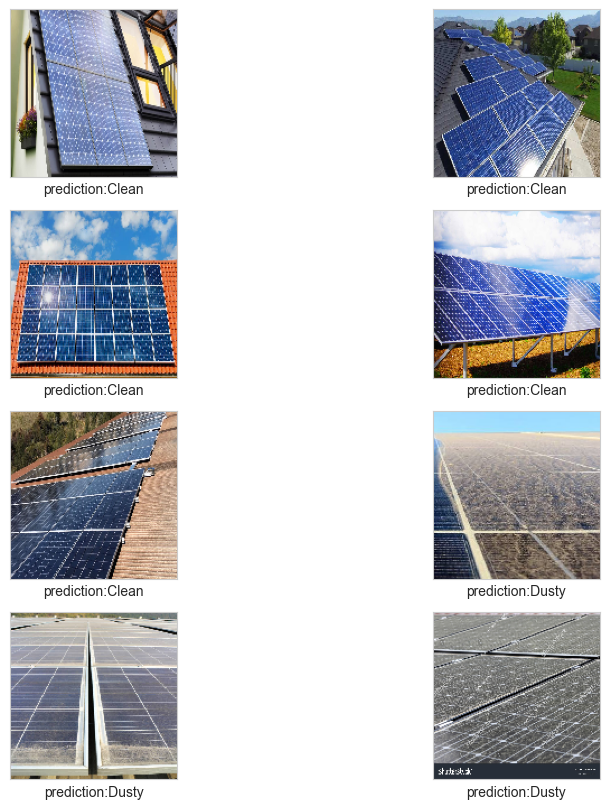

In [23]:
test_img(model_tuned_2) 

### Data Reference:

Sai, H. (2022) Solar Panel dust detection. www.kaggle.com. Available online: 
https://www.kaggle.com/datasets/hemanthsai7/solar-panel-dust-detection.